In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from learning_utils import pickle_load, pickle_save, construct_pipeline, Participant, create_dir, rows_mean, get_normalized_features
from generic_mouselab import GenericMouselabEnv
from modified_mouselab import TrialSequence, reward_val, normal_reward_val
from rl_models import models as rl_models
from rl_models import ModelRunner
from IPython.display import display
from sequence_utils import get_termination_mers

In [2]:
strategy_spaces = {'participant': [6, 11, 14, 16, 17, 18, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 37, 39, 40, 42, 43, 44, 50, 56, 57, 58,
                                    63, 64, 65, 67, 70, 76, 79, 87, 88],
                  'microscope': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32,
                                33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
                                63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 82, 84, 85, 86, 87, 88, 89]}
def string_to_bool(s):
    if not s:
        return s
    if s.lower() == "true":
         return True
    else:
        return False

In [3]:
def get_mer_df(df):
    AMER = {}
    PMER = {}
    vals = df.values
    pipeline = pickle_load("data/exp_pipelines.pkl")["F1"]*5
    ['pid', 'model', 'criterion', 'base_learner', 'decision_rule', 'pr', 'prw', 'term', 'mode', 'NUM_PARAMS', 'NLL', 'AIC', 'A', 'R']
    for v in vals:
        participant = Participant("F1", v[0])
        AS = v[12]
        envs = participant.envs
        total_MERS = []
        for As in AS:
            MERS = get_termination_mers(envs, As, pipeline)
            total_MERS.append(MERS)
        a_mers = np.mean(total_MERS, axis = 0)
        p_mers = get_termination_mers(envs, participant.clicks, pipeline)
        AMER[v[0]] = a_mers
        PMER[v[0]] = p_mers
    return AMER, PMER

In [4]:
ds_models = ['ds', "vicarious_ds", "cost_ds", "montecarlo_ds",
          "termination_ds", "termination_montecarlo_ds", "full_ds",
          "cost_term_mc_ds"]

base_lvoc_models = ["lvoc", "vicarious_lvoc", "cost_lvoc", "montecarlo_lvoc", "termination_lvoc",
            "termination_montecarlo_lvoc", "full_lvoc", "cost_term_mc_lvoc"]
lvoc_models = ["lvoc"]
models = ["lvoc", "vicarious_lvoc", "cost_lvoc", "montecarlo_lvoc", "termination_lvoc",
            "termination_montecarlo_lvoc", "full_lvoc", "cost_term_mc_lvoc", "null_lvoc"]
reinforce_models = ["reinforce", "baseline_reinforce"]

rssl_models = ["bernoulli_rssl", "gaussian_rssl", "null_bernoulli_rssl", "null_gaussian_rssl"]
strategy_modes = ["participant", "microscope"]

decision_rules = ["threshold", "adaptive_satisficing", "confidence_bound"]

criteria = ["reward", "performance_error"]
prs = ["true", "false"]
prws = ["true", "false"]
terms = ["true", "false"]
modes = ["participant", "microscope"]

In [5]:
lvoc_eps = defaultdict(list)

In [16]:
data = []
control_pids = [1, 2, 6, 9, 11, 14, 18, 21, 24, 27, 37, 38, 44, 50, 55, 56, 58, 66, 76, 79, 85, 89, 90, 98, 99,
                100, 104, 111, 113, 118, 119, 123, 126, 129, 139, 142, 144, 153, 154]
columns = ['pid', 'model', 'criterion', 'base_learner', 'decision_rule', 'pr', 'prw', 'term', 'mode', 'NUM_PARAMS', 'NLL', 'AIC', 'A', 'R']
base_results_path = "results/temp_results"
criterion = "likelihood"
base_learner = None
decision_rule = None
term = None
mode = None
for model in lvoc_models:
    for pid in control_pids:
        for pr in prs:
            for prw in prws:
                if not (not pr and prw):
                    temp_model = model
                    temp_model += "_op"
                    if pr == "true":
                        temp_model += "_pr"
                    if prw == "true" and pr == "true":
                        temp_model += "_prw"
                    try:
                        model_res = pickle_load(f"{base_results_path}/{temp_model}/{criterion}/normalized/{pid}.pkl")
                    except Exception as e:
                        continue
                    lvoc_eps[f"{model}_{pr}_{prw}"].append(model_res['params']['eps'])
                    num_params = len(model_res['params'])
                    nll = model_res['loss']
                    AIC = 2*num_params + 2*nll
                    A = model_res['a']
                    R = np.mean(model_res['r'], axis=0)
                    data.append([pid, model, criterion, base_learner, decision_rule, pr, prw, term, mode, num_params, nll, AIC, A, R])

In [17]:
print(data)

[[1, 'lvoc', 'likelihood', None, None, 'true', 'true', None, None, 60, 330.38788528975897, 780.7757705795179, [[[5, 1, 2, 4, 3, 9, 10, 11, 12, 7, 6, 8, 0], [6, 4, 3, 2, 12, 9, 7, 8, 1, 5, 0], [11, 6, 1, 5, 9, 7, 8, 3, 10, 12, 4, 0], [8, 0], [10, 8, 6, 7, 11, 0], [8, 11, 7, 6, 5, 3, 12, 0], [8, 7, 2, 11, 6, 0], [8, 7, 3, 4, 6, 11, 12, 0], [8, 7, 6, 1, 3, 12, 11, 10, 0], [10, 2, 8, 0], [6, 8, 1, 7, 4, 11, 3, 9, 12, 0], [3, 12, 11, 8, 7, 9, 5, 6, 4, 10, 2, 0], [8, 2, 6, 7, 11, 1, 3, 10, 12, 5, 0], [8, 7, 3, 6, 0], [8, 12, 7, 3, 11, 4, 6, 5, 0], [8, 7, 10, 3, 11, 4, 12, 0], [5, 9, 2, 0], [8, 10, 9, 7, 3, 6, 2, 1, 5, 11, 4, 12, 0], [4, 8, 7, 11, 3, 6, 5, 12, 10, 9, 0], [8, 2, 7, 9, 11, 3, 12, 4, 0], [7, 2, 9, 12, 8, 4, 1, 11, 0], [8, 10, 7, 5, 11, 6, 12, 3, 9, 4, 2, 1, 0], [8, 12, 11, 10, 2, 6, 7, 1, 3, 5, 0], [8, 7, 6, 11, 12, 10, 3, 0], [12, 4, 0], [8, 7, 4, 11, 12, 2, 10, 3, 0], [4, 8, 9, 7, 1, 11, 0], [8, 4, 1, 7, 6, 10, 12, 5, 9, 11, 0], [2, 7, 8, 3, 6, 11, 5, 10, 1, 9, 12, 4, 0], [6, 

In [18]:
for model in reinforce_models:
    for pid in control_pids:
        for pr in prs:
            for prw in prws:
                temp_model = model
                temp_model += "_op"
                if pr == "true":
                    temp_model += "_pr"
                if prw == "true" and pr == "true":
                    temp_model += "_prw"
                model_res = pickle_load(f"{base_results_path}/{temp_model}/{criterion}/normalized/{pid}.pkl")
                num_params = len(model_res['params'])
                nll = model_res['loss']
                AIC = 2*num_params + 2*nll
                A = model_res['a']
                R = np.mean(model_res['r'], axis=0)
                data.append([pid, model, criterion, base_learner, decision_rule, pr, prw, term, mode, num_params, nll, AIC, A, R])

In [237]:
for model in rssl_models:
    for pid in control_pids:
        for pr in prs:
            for prw in prws:
                for mode in modes:
                    temp_model = model
                    if pr == "true":
                        temp_model += "_pr"
                    if prw == "true" and pr == "true":
                        temp_model += "_prw"
                    temp_model += "_"+mode
                    try:
                        model_res = pickle_load(f"{base_results_path}/{temp_model}/{criterion}/normalized/{pid}.pkl")
                    except Exception as e:
                        print(e)
                    num_params = len(model_res['params'])
                    nll = model_res['loss']
                    AIC = 2*num_params + 2*nll
                    R = np.mean(model_res['r'], axis=0)
                    A = model_res['a']
                    data.append([pid, model, criterion, base_learner, decision_rule, pr, prw, term, mode, num_params, nll, AIC, A, R])

results/temp_results/bernoulli_rssl_pr_prw_microscope/likelihood/normalized/1.pkl not found.
results/temp_results/bernoulli_rssl_pr_microscope/likelihood/normalized/1.pkl not found.
results/temp_results/bernoulli_rssl_microscope/likelihood/normalized/1.pkl not found.
results/temp_results/bernoulli_rssl_microscope/likelihood/normalized/1.pkl not found.
results/temp_results/bernoulli_rssl_pr_prw_microscope/likelihood/normalized/2.pkl not found.
results/temp_results/bernoulli_rssl_pr_microscope/likelihood/normalized/2.pkl not found.
results/temp_results/bernoulli_rssl_microscope/likelihood/normalized/2.pkl not found.
results/temp_results/bernoulli_rssl_microscope/likelihood/normalized/2.pkl not found.
results/temp_results/bernoulli_rssl_pr_prw_microscope/likelihood/normalized/6.pkl not found.
results/temp_results/bernoulli_rssl_pr_microscope/likelihood/normalized/6.pkl not found.
results/temp_results/bernoulli_rssl_microscope/likelihood/normalized/6.pkl not found.
results/temp_results/ber

results/temp_results/gaussian_rssl_pr_microscope/likelihood/normalized/58.pkl not found.
results/temp_results/gaussian_rssl_microscope/likelihood/normalized/58.pkl not found.
results/temp_results/gaussian_rssl_microscope/likelihood/normalized/58.pkl not found.
results/temp_results/gaussian_rssl_pr_microscope/likelihood/normalized/66.pkl not found.
results/temp_results/gaussian_rssl_microscope/likelihood/normalized/66.pkl not found.
results/temp_results/gaussian_rssl_microscope/likelihood/normalized/66.pkl not found.
results/temp_results/gaussian_rssl_pr_prw_microscope/likelihood/normalized/79.pkl not found.
results/temp_results/gaussian_rssl_microscope/likelihood/normalized/79.pkl not found.
results/temp_results/gaussian_rssl_microscope/likelihood/normalized/79.pkl not found.
results/temp_results/gaussian_rssl_pr_prw_microscope/likelihood/normalized/85.pkl not found.
results/temp_results/gaussian_rssl_microscope/likelihood/normalized/85.pkl not found.
results/temp_results/gaussian_rssl

results/temp_results/null_bernoulli_rssl_microscope/likelihood/normalized/139.pkl not found.
results/temp_results/null_bernoulli_rssl_microscope/likelihood/normalized/139.pkl not found.
results/temp_results/null_bernoulli_rssl_pr_prw_microscope/likelihood/normalized/142.pkl not found.
results/temp_results/null_bernoulli_rssl_pr_microscope/likelihood/normalized/142.pkl not found.
results/temp_results/null_bernoulli_rssl_pr_prw_microscope/likelihood/normalized/144.pkl not found.
results/temp_results/null_bernoulli_rssl_pr_microscope/likelihood/normalized/144.pkl not found.
results/temp_results/null_bernoulli_rssl_microscope/likelihood/normalized/144.pkl not found.
results/temp_results/null_bernoulli_rssl_microscope/likelihood/normalized/144.pkl not found.
results/temp_results/null_bernoulli_rssl_pr_prw_microscope/likelihood/normalized/153.pkl not found.
results/temp_results/null_bernoulli_rssl_microscope/likelihood/normalized/153.pkl not found.
results/temp_results/null_bernoulli_rssl_mi

In [341]:
mode = None
for model in ["hierarchical_learner"]:
    for pid in control_pids:
        for pr in prs:
            for prw in prws:
                for term in terms:
                    for base_learner in base_lvoc_models:
                        for decision_rule in decision_rules:
                            temp_model = base_learner + "_" + decision_rule
                            temp_model += "_op"
                            if pr == "true":
                                temp_model += "_pr"
                            if prw == "true" and pr == "true":
                                temp_model += "_prw"
                            if term == "true":
                                temp_model += "_term"
                            try:
                                model_res = pickle_load(f"{base_results_path}/{model}/{temp_model}/{criterion}/normalized/{pid}.pkl")
                                lvoc_eps[f"{model}_{base_learner}_{pr}_{prw}_{term}"].append(model_res['params']['eps'])
                            except Exception as e:
                                print(e)
                            num_params = len(model_res['params'])
                            nll = model_res['loss']
                            AIC = 2*num_params + 2*nll
                            R = np.mean(model_res['r'], axis=0)
                            A = model_res['a']
                            data.append([pid, model, criterion, base_learner, decision_rule, pr, prw, term, mode, num_params, nll, AIC, A, R])

results/temp_results/hierarchical_learner/lvoc_threshold_op_pr_prw/likelihood/normalized/24.pkl not found.
results/temp_results/hierarchical_learner/cost_term_mc_lvoc_threshold_op_pr_prw/likelihood/normalized/24.pkl not found.
results/temp_results/hierarchical_learner/cost_term_mc_lvoc_adaptive_satisficing_op_pr_prw/likelihood/normalized/24.pkl not found.
results/temp_results/hierarchical_learner/cost_term_mc_lvoc_confidence_bound_op_pr_prw/likelihood/normalized/24.pkl not found.
results/temp_results/hierarchical_learner/lvoc_threshold_op_pr_prw/likelihood/normalized/153.pkl not found.
results/temp_results/hierarchical_learner/cost_term_mc_lvoc_threshold_op_pr_prw/likelihood/normalized/153.pkl not found.
results/temp_results/hierarchical_learner/cost_term_mc_lvoc_adaptive_satisficing_op_pr_prw/likelihood/normalized/153.pkl not found.
results/temp_results/hierarchical_learner/cost_term_mc_lvoc_confidence_bound_op_pr_prw/likelihood/normalized/153.pkl not found.


In [342]:
d = f"results/lvoc_eps_plots"
create_dir(d)
for k,v in lvoc_eps.items():
    plt.figure()
    plt.title(k)
    sns.distplot(lvoc_eps[k])
    plt.savefig(f"{d}/{k}.png")
    plt.close()

[0.7479901327628432, 0.6646159943740945, 0.538735726791528, 0.1416191783465176, 0.37081291072150574, 0.7210817375189503, 0.6192682149977449, 0.5057679880206979, 0.01588209688806663, 0.7228838957399413, 0.5365745097956329, 0.7225933718998383, 0.6878063335773561, 0.5981902143262043, 0.5727116419938941, 0.6412795737646275, 0.3539279339576929, 0.7979379955137342, 0.46477362860848037, 0.4968781915584807, 0.44432301976224653, 0.6975704235097018, 0.696776238503108, 0.7149175503172053, 0.5441934710988008, 0.635097685304445, 0.0034853003407917613, 0.8513839146157942, 0.5142982128675198, 0.7678189775545476, 0.710682226015468, 0.6982627922888489, 0.7483280718938933, 0.15781092193772217, 0.7139763763756389, 0.49995761524441984, 0.4093613352993285, 0.002010803159948117, 0.46411991092832555]
[0.7550945503387183, 0.5881259399766039, 0.38927389971115134, 0.1492502689753159, 0.5151509559996598, 0.7962148862080761, 0.5750817808398355, 0.7580498991551875, 0.001387697209071036, 0.5228065878995295, 0.52127

[0.6834875341097315, 0.5349615693930185, 0.6782055851145448, 0.14531436086010735, 0.2325483094611212, 0.7624036053474326, 0.7374800500796143, 0.6817358349207032, 0.0012924194545622936, 0.7287051770878746, 0.6607722491596866, 0.5977683413302984, 0.6138305142407168, 0.5396393834617843, 0.51269753058662, 0.8481375549269387, 0.8018425815314615, 0.8705877935003953, 0.6583695720541735, 0.6074432369384865, 0.5480943453043322, 0.6853849995179758, 0.8485957196689148, 0.6522338928377439, 0.6050504584131263, 0.6902687655043835, 0.024669034180829552, 0.7942985225149133, 0.5158851278223506, 0.7919006140028535, 0.6156936125038168, 0.5670727412141108, 0.7078538755590946, 0.10263327062430155, 0.7473170258550652, 0.43075433330521806, 0.4365689400653358, 0.0010648029224568508, 0.5750709665557958]
[0.7001696748686184, 0.6702454136934847, 0.31890087241990067, 0.14919570198255983, 0.2997488321324355, 0.6329940818226713, 0.6204314975006527, 0.629216384153554, 0.00176922102184849, 0.5986933490367257, 0.48746

[0.4941181679093972, 0.6304703756694724, 0.48491321238489665, 0.27216312784457614, 0.5389889289773818, 0.6675780647836252, 0.7167307832139709, 0.5538927088581658, 0.0018020933617244224, 0.46235474082700867, 0.6891261045186852, 0.6829991540010464, 0.5617451030045785, 0.4182270432932084, 0.5618015421269335, 0.4822397296032156, 0.5268930231175022, 0.7027794901011728, 0.47149922671458755, 0.2747265930917006, 0.6455033310076165, 0.44933789910369815, 0.8110781146286378, 0.5829784904083164, 0.750056125055146, 0.6276220879257842, 0.08455003200780475, 0.5175707045959949, 0.44944825543636485, 0.7522601690985867, 0.7772420398719337, 0.7268496711700603, 0.7928094338903879, 0.15392992172179115, 0.7706042469135923, 0.46084690123167055, 0.43595594421549655, 0.0016265382018110918, 0.7059607253689129]
[0.4941181679093972, 0.6304703756694724, 0.48491321238489665, 0.27216312784457614, 0.5389889289773818, 0.6675780647836252, 0.7167307832139709, 0.5538927088581658, 0.0018020933617244224, 0.4623547408270086

[0.8677109343443171, 0.7607084031464683, 0.9994580650763111, 0.8661636337181419, 0.7116693563688365, 0.8531146059095083, 0.6402217841023732, 0.7378840214881544, 0.7727572556604252, 0.10959003204251785, 0.19185899266196366, 0.18031857518314076, 0.3490971625561414, 0.36527993637242967, 0.7467010124029655, 0.9030367078273416, 0.7284071293758296, 0.9182541565893112, 0.8001494988788239, 0.8392358370893518, 0.5234633731577278, 0.9001505820866161, 0.9489724657438159, 0.8165679049429466, 0.0011862530361679013, 0.002369439866584777, 0.013533808732289163, 0.6142314148665033, 0.7823350930077226, 0.588448476283475, 0.525107970014504, 0.47381805256577225, 0.27342600036981335, 0.6575967516950023, 0.7825748976173817, 0.8420011002667691, 0.7426157476062698, 0.8340335126282945, 0.800884233785041, 0.868658111698226, 0.49564867129076573, 0.7547654062141833, 0.9130706054611505, 0.6439362245101828, 0.5931757855659335, 0.9693013509475195, 0.7165202375668748, 0.8752241159773101, 0.7020716114828716, 0.9128629

[0.7115426058515957, 0.8109555635927205, 0.7404885983441878, 0.7019275170321531, 0.5186722124359929, 0.7141394049939028, 0.6819328887160614, 0.780604346811129, 0.5475374275472656, 0.12191592488203912, 0.27798547637172877, 0.18015232964964795, 0.6352571308188667, 0.6095611817557257, 0.3954627916499382, 0.8918045461340587, 0.8818584841417991, 0.8026652884113081, 0.9160693526168283, 0.746659517067854, 0.8621854233401709, 0.5802024190097288, 0.7345004398345489, 0.7558538780923247, 0.0015464127964244822, 0.002592064542158729, 0.007632598542812367, 0.926125637267968, 0.6957774613401038, 0.6903042187361917, 0.10543051800590675, 0.630599660416924, 0.6080897216869151, 0.7600713392969125, 0.8520627882863884, 0.8228715029598437, 0.4016260394894981, 0.8830301701063794, 0.8473851723450626, 0.7060757141157212, 0.7323967334565127, 0.7084654637554175, 0.7216742863762226, 0.7608836543250708, 0.5898296527886568, 0.8678824849261273, 0.8719872216108298, 0.9910909440969251, 0.9068782853686062, 0.8637736454

[0.7463858252712361, 0.5716981766369681, 0.490261751575292, 0.449277659667652, 0.6533000276116918, 0.6010614275946143, 0.8098591734773544, 0.5258865749559584, 0.39241601752922417, 0.9691689206750577, 0.01280276275022292, 0.04122368773239519, 0.06223105434840476, 0.25013701204172994, 0.053156212805615666, 0.9943735350263115, 0.9846912381958818, 0.8997673144396326, 0.7410327721695664, 0.8405593747465677, 0.6694008302762231, 0.9008563294297427, 0.6752793523153576, 0.6454648478256471, 0.13088661714697222, 0.0017283085046144557, 0.08740083527055836, 0.6236927213159622, 0.4505365671508637, 0.5972744866500814, 0.3033990930988665, 0.12336553528651706, 0.36377935307236564, 0.7533697154066347, 0.7626941105825915, 0.6791383105233049, 0.7980989507334522, 0.731170925319617, 0.6489369736559613, 0.7624775396191459, 0.8885119911147926, 0.5293564798062187, 0.7458188461837475, 0.003661394355236172, 0.06933182446727636, 0.8949289425025828, 0.8910500364945282, 0.6509693253707675, 0.6277481170421441, 0.552

[0.7361692978334662, 0.5392713869696113, 0.6727823372126962, 0.5417981011336199, 0.7959382482381563, 0.6098197732479117, 0.5913073444261141, 0.46821868629503355, 0.6250992430782745, 0.7517053706397143, 0.003513449961089432, 0.060729913461721914, 0.32939470467694454, 0.35492111401572957, 0.003540740359771352, 0.9970807675559822, 0.7772150315909736, 0.7962798451093508, 0.6329320800400393, 0.6569814757179497, 0.6266296977204543, 0.6695150665000812, 0.7378174306280793, 0.6071539298253585, 0.7532067247092323, 0.6152232878779558, 0.7015799007570633, 0.5835116804937015, 0.3314206050100371, 0.22379622908213623, 0.8511259114724454, 0.8679511543315043, 0.7119886736884232, 0.516481606525455, 0.7415378504588432, 0.6053769463958654, 0.6893627584211826, 0.864492944214998, 0.7058055345413635, 0.004403196796584713, 0.3180846427791607, 0.272465058167713, 0.9688815218708206, 0.48776257539895385, 0.9384727635144073, 0.3847777667658336, 0.36809430689988665, 0.8274564545295257, 0.8656337779792351, 0.960584

[0.6083562280387724, 0.9491620644096267, 0.8298104485481728, 0.5828707553025734, 0.5998329292076034, 0.6998371023628093, 0.5962166266761831, 0.8418133806793089, 0.7384556861391328, 0.09778973981294524, 0.21772277522239303, 0.27362380663810243, 0.4840216470278848, 0.509303525873281, 0.46574030539090083, 0.9872395418050148, 0.8851796212713747, 0.9932859078372318, 0.8033061813862328, 0.7319347917862297, 0.6381752933169204, 0.6351142879783185, 0.8558857666714351, 0.615410789907474, 0.0010165655826563681, 0.0011731813169444107, 0.03897642578459119, 0.7717660345263254, 0.7598170547610251, 0.5903685845724677, 0.8251034350790958, 0.5470211866018632, 0.5055030763581774, 0.7571438009947332, 0.666896955038216, 0.7288822946778478, 0.7311751477822144, 0.9372619375510665, 0.5437540808027752, 0.7110392424645035, 0.7494126619098747, 0.6221408114226139, 0.5033018046571405, 0.5101533402095109, 0.6858326532744086, 0.5374464283556198, 0.969349666149551, 0.6273446819275577, 0.8883548005031908, 0.9729699619

[0.8872368876728414, 0.8701701444037911, 0.826164314135621, 0.7631590724516564, 0.5958452469013931, 0.6596776835882, 0.6803530102895403, 0.40322383893780966, 0.7458115231686345, 0.0627817835945671, 0.20997836990516244, 0.33472410715589496, 0.5636719215660673, 0.4361787473647871, 0.41454722035937297, 0.9020113800741232, 0.833007399011882, 0.8825305804988283, 0.7087300380074864, 0.8703754005876597, 0.694910397063481, 0.8270284825604144, 0.6563243135019877, 0.8102439687866839, 0.059010605798383214, 0.03234979804440379, 0.003901195071429317, 0.8807564700565597, 0.6832839630800919, 0.6910048466417764, 0.8908246916169981, 0.7632797901789877, 0.48150734946416335, 0.8271282494662594, 0.7947364868611475, 0.7569519778858321, 0.6657453724559523, 0.6287241388394074, 0.697605370848134, 0.639070563097944, 0.42507322022920113, 0.36957967786368734, 0.5802341194875408, 0.7267528815457881, 0.7282400883682927, 0.934568353779437, 0.7456926613979166, 0.6376468916200583, 0.7603248270367304, 0.76260528174955

[0.868337804230612, 0.9102458406923133, 0.4738141767988306, 0.3760392000417184, 0.7717491900423162, 0.5438174317106999, 0.8800095239298307, 0.5233605535647861, 0.6943239715337661, 0.24473395403834225, 0.09661528567139917, 0.08912174939640743, 0.21704391734925554, 0.48060297937134083, 0.24600369709771214, 0.8525344452998398, 0.6142781183212416, 0.792278855376223, 0.681867925384062, 0.3821457213616486, 0.47292173500958223, 0.8449988793589922, 0.582691201538794, 0.7087444760678576, 0.0023436220001662317, 0.004537750706893551, 0.10821135959131117, 0.6290997038993934, 0.597196386338074, 0.7339347231306997, 0.04506241242174511, 0.022203238805940547, 0.21261792034057395, 0.7163365464002349, 0.8085374835996838, 0.8146828586806122, 0.5537904703851417, 0.8146363488112397, 0.7131510345870128, 0.45079900208420864, 0.3356623881027286, 0.5698450393041778, 0.16846536739901635, 0.002999331171394178, 0.1280872073227939, 0.3034096288382126, 0.41649338305484135, 0.5480031637125874, 0.5451289281631184, 0.

[0.5861784980863294, 0.5226632189719875, 0.883438457508027, 0.6494968783207623, 0.4511441736064649, 0.6237905383609023, 0.6594581713515586, 0.21938886811379668, 0.5328010663074864, 0.07159447557260844, 0.28314280064090486, 0.9582066027478191, 0.16518254192645454, 0.10861785298821722, 0.005105807550256348, 0.8317779793239717, 0.6436780343856184, 0.7827829058681086, 0.6589613046848986, 0.5767828123684071, 0.5728996727493753, 0.5277253407805994, 0.6601202481800338, 0.6373715615020472, 0.0012606155714453005, 0.0012651395360362087, 0.00171500950904144, 0.5434347618983882, 0.46978918508767803, 0.7938212727825588, 0.6426913338877234, 0.5393580549502197, 0.09032880653534148, 0.7670926442452066, 0.7818471653534431, 0.7945766578778429, 0.703052031588143, 0.7132910220939178, 0.8331431152380084, 0.7403327455120684, 0.4076208968950633, 0.7005006487176478, 0.1750534933160791, 0.32051175826515815, 0.0031214446706053986, 0.37933508961586565, 0.543758310565493, 0.16831492689700933, 0.5806433450212312, 

[0.9123649927800812, 0.9695780234140293, 0.9179890332768956, 0.6739183363365326, 0.47277544551016404, 0.7035649217629983, 0.6877019324916782, 0.7484521577049895, 0.43074920562952357, 0.3511887480282906, 0.10822515778571097, 0.14536411254679732, 0.4753784281899964, 0.38915542104175793, 0.3650012683951266, 0.7697681768617469, 0.9329009740841161, 0.910568046214318, 0.5241126922231738, 0.997552366642233, 0.5281345980777495, 0.971372198938176, 0.6258575496835365, 0.8339809857041214, 0.001965994040124267, 0.006172681209120433, 0.0094005720361722, 0.8060280738880562, 0.5262741993689547, 0.646165596804071, 0.4428413644653605, 0.36522856203845455, 0.7232168059471389, 0.7917743574840458, 0.708046254140042, 0.7530638680000847, 0.7159910884488749, 0.3640304456083622, 0.5097292446730656, 0.5343465384075666, 0.4513135652691705, 0.3851872778543541, 0.8703499396010048, 0.48741614468592964, 0.6781142661919974, 0.7455643247684703, 0.9136230325886459, 0.9940866424251887, 0.9337054938058967, 0.53711149735

[0.9239868070931039, 0.9436294970683535, 0.6961418833735386, 0.7895427555577856, 0.8049692067883237, 0.6517599826210819, 0.6176125431918839, 0.6587566842524496, 0.6840328351859852, 0.10704011412187321, 0.11536938803629021, 0.01985022622487087, 0.4001329528830995, 0.2968167565051331, 0.10533883616303313, 0.9477037915188427, 0.8799836474853858, 0.5559342209793635, 0.5880485807954685, 0.6195847741256071, 0.6996173328633782, 0.5800255604570373, 0.9459107718152581, 0.5877168945726855, 0.001198556108785358, 0.022842734552740322, 0.0028718846672451653, 0.9539877278823848, 0.8239811352064084, 0.7796029591123498, 0.5261995376716152, 0.5190641745782762, 0.6668871674275548, 0.6155486504389324, 0.912391619793836, 0.6847081891794746, 0.948668538290161, 0.49028425290887967, 0.7441926080366573, 0.581176323622916, 0.8147523626902062, 0.7347027131743317, 0.6516992111911607, 0.7415113318690808, 0.5878067973268497, 0.6055770434243172, 0.8231530850377343, 0.6593132218847437, 0.8054383931960678, 0.65775516

[0.829173720385644, 0.5011461603881985, 0.4427710027511882, 0.9272111569736852, 0.9975555985093155, 0.5906644958740628, 0.6996080840699885, 0.699987150116143, 0.561898637452316, 0.014321650746872555, 0.0016569577716931683, 0.37232050364077984, 0.09880903348186537, 0.12875902777863354, 0.30735561116126975, 0.8911201725037124, 0.5610017630378223, 0.897605270503206, 0.7967696686935806, 0.42557493430335647, 0.627975028646967, 0.7786246904012104, 0.8923801036143814, 0.7630412470548926, 0.026636815107338008, 0.0033841183762332028, 0.9985507687300348, 0.7847256085900248, 0.6444385917291636, 0.7469053538280308, 0.4303251239373107, 0.5534703799964483, 0.47137627074653243, 0.756892987880953, 0.6841513650534236, 0.7356549964202274, 0.8707286519301316, 0.8328412698249379, 0.355378971282997, 0.654905506623097, 0.5260694327895713, 0.4001481065542978, 0.0015092442687849594, 0.0029491837537002213, 0.09706450446097728, 0.9951186446281955, 0.7606755080846126, 0.8265355361164786, 0.7451818998347844, 0.70

[0.9007143783109011, 0.7255068794674921, 0.7095434618348455, 0.7339188981196365, 0.9368227126720509, 0.6218885704822473, 0.5952512464880818, 0.45804834367772906, 0.48212646121811276, 0.18387331655285646, 0.11535848968617116, 0.1328318313965783, 0.3616638173235531, 0.5231481209580054, 0.47725898114739207, 0.7252992069320033, 0.8753056625521081, 0.8384979972388031, 0.837750340023705, 0.7695644176232572, 0.47289220386809094, 0.8252075664108827, 0.940789783699207, 0.6925638806153646, 0.011755491343314772, 0.001834271966883301, 0.009707436558851382, 0.6463677849599433, 0.8069859182095606, 0.8200551885938727, 0.6194326247174434, 0.5138585443150654, 0.7142887676828688, 0.6633921375728373, 0.7910704164150701, 0.7729756587735132, 0.2569865908178515, 0.8490038546316574, 0.6281809814461485, 0.46840857436906547, 0.6371127894196476, 0.8796569313264265, 0.949533215167085, 0.47021874078189624, 0.5981423814651262, 0.9547983987591803, 0.4485520653451087, 0.41852315175678656, 0.7604088773924624, 0.61615

[0.8761715943663186, 0.7713876417084695, 0.8233533464047379, 0.4230703491677934, 0.6330069467321114, 0.7770502551757259, 0.24677903708049392, 0.5320073568831223, 0.299865026058013, 0.291596280315247, 0.1718312681587199, 0.09954466406148593, 0.42556028769771703, 0.46445662924052045, 0.5363736808627221, 0.6339627239815235, 0.8599723098272474, 0.5361724847058847, 0.7119917747048683, 0.582240937210247, 0.6617902084132007, 0.6784555146057983, 0.995547754617947, 0.7433031430567787, 0.0030301133311386235, 0.0014760495069719992, 0.03015891697401543, 0.5957985273683666, 0.4422910915392936, 0.3695326396989638, 0.5318869917509179, 0.6417455905935957, 0.5485749514643325, 0.8568985183352339, 0.5200188392603382, 0.738913553222614, 0.7038030541081786, 0.8685061948363183, 0.4506802830256941, 0.6853943493510402, 0.5870005426486007, 0.5685835666197728, 0.6457332037570861, 0.4046672511327555, 0.6258953037871072, 0.7098577616064846, 0.8531837684224522, 0.837813939668153, 0.8868098354219316, 0.834269494194

[0.8501019994004627, 0.6665314484439504, 0.7431938973042043, 0.5787883837352864, 0.5048736323880508, 0.8122376328191132, 0.7075083620121216, 0.38399139238374025, 0.9994133004659203, 0.3826737662290925, 0.029606266230595535, 0.002096550371013972, 0.28331288887450945, 0.008943932462584375, 0.5671529250598268, 0.9252314087581922, 0.910808878063231, 0.8451882386392918, 0.23606781264411833, 0.5535911413748162, 0.4624285498843057, 0.572853940203823, 0.7270278261552796, 0.6875862869892542, 0.0017952838971227666, 0.018818111777047467, 0.0019625228140729423, 0.685713989678418, 0.9641111304717696, 0.6172096228933591, 0.059414937944454294, 0.7828056823370471, 0.4555574243543481, 0.9813748584346703, 0.6690729423518514, 0.7625392689052234, 0.6246594953439484, 0.9506867616827593, 0.6985919037785868, 0.927486122857985, 0.4493056731366352, 0.8280462365086159, 0.07365500733488103, 0.12668091128468836, 0.1794763178538865, 0.9115581212616275, 0.9891939189706371, 0.6601014463579464, 0.7364248259192672, 0.

[0.907415204016459, 0.8612335053235246, 0.5215133238668355, 0.8938276964942662, 0.7068329939966016, 0.800802707666257, 0.5680974919972589, 0.9999313747040989, 0.19466136387996613, 0.9944327038305808, 0.25651402889172403, 0.13434627984517067, 0.8795694788728062, 0.43460671875191703, 0.3407837364580612, 0.6970967284521471, 0.9002721800253459, 0.7878060647181477, 0.5318810986936345, 0.9994080011630092, 0.3537663528401661, 0.7251797550566169, 0.5034376400545378, 0.651607824106551, 0.001057218065492544, 0.0019376195965126915, 0.04243813441788725, 0.9009937260211786, 0.9679050345206206, 0.3762409711815993, 0.5322859886668792, 0.02116992499542446, 0.5592426463673648, 0.9618202186262884, 0.9201947696553762, 0.991399456368685, 0.846145948183786, 0.8955465651628521, 0.7347588712371566, 0.6464923227859029, 0.840245272083995, 0.4046735935186023, 0.1606075450966863, 0.007273900529852301, 0.0994498433620869, 0.5113568477918748, 0.49135039031398936, 0.5988000117809649, 0.5401303158388784, 0.692540761

In [19]:
df = pd.DataFrame(data, columns=columns)

In [21]:
print(df[df.pid == 2])

     pid               model   criterion base_learner decision_rule     pr  \
4      2                lvoc  likelihood         None          None   true   
5      2                lvoc  likelihood         None          None   true   
6      2                lvoc  likelihood         None          None  false   
7      2                lvoc  likelihood         None          None  false   
150    2           reinforce  likelihood         None          None   true   
151    2           reinforce  likelihood         None          None   true   
152    2           reinforce  likelihood         None          None  false   
153    2           reinforce  likelihood         None          None  false   
306    2  baseline_reinforce  likelihood         None          None   true   
307    2  baseline_reinforce  likelihood         None          None   true   
308    2  baseline_reinforce  likelihood         None          None  false   
309    2  baseline_reinforce  likelihood         None          N

In [22]:
x = df.groupby(['pid', 'criterion'], as_index=False)['AIC'].idxmin()
y = df.groupby(['pid', 'criterion'], as_index=False)['AIC'].min()
z = y.copy()
z['AIC'] = z['AIC'] + 3
z.set_index('pid', inplace=True)
z_dict = z['AIC'].to_dict()
x = df.groupby(['pid', 'criterion'], as_index=False)
x = df.apply(lambda k: k['AIC'] <= z_dict[k['pid']], axis=1)
mod_df = df[x]
mod_df = mod_df.sort_values('pid')
cols2 = columns.copy()
cols2.remove('R')
cols2.remove('A')
best_df = mod_df
display_df = best_df[cols2]
display_df = display_df[display_df.pid.isin(control_pids)]
display(display_df)

pid               model   criterion base_learner decision_rule     pr  \
302    1  baseline_reinforce  likelihood         None          None   true   
147    1           reinforce  likelihood         None          None   true   
307    2  baseline_reinforce  likelihood         None          None   true   
156    6           reinforce  likelihood         None          None  false   
157    6           reinforce  likelihood         None          None  false   
315    9  baseline_reinforce  likelihood         None          None   true   
161    9           reinforce  likelihood         None          None  false   
160    9           reinforce  likelihood         None          None  false   
162   11           reinforce  likelihood         None          None   true   
166   14           reinforce  likelihood         None          None   true   
171   18           reinforce  likelihood         None          None   true   
332   21  baseline_reinforce  likelihood         None          None  false   
333   21  baseline_reinforce  likelihood         None          None  false   
181   24           reinforce  likelihood         None          None  false   
336   24  baseline_reinforce  likelihood         None          None  false   
335   24  baseline_reinforce  likelihood         None          None   true   
337   24  baseline_reinforce  likelihood         None          None  false   
180   24           reinforce  likelihood         None          None  false   
32    24                lvoc  likelihood         None          None   true   
178   24           reinforce  likelihood         None          None   true   
33    24                lvoc  likelihood         None          None   true   
34    24                lvoc  likelihood         None          None  false   
35    24                lvoc  likelihood         None          None  false   
179   24           reinforce  likelihood         None          None   true   
182   27           reinforce  likelihood         None          None   true   
186   37           reinforce  likelihood         None          None   true   
191   38           reinforce  likelihood         None          None   true   
194   44           reinforce  likelihood         None          None   true   
201   50           reinforce  likelihood         None          None  false   
200   50           reinforce  likelihood         None          None  false   
..   ...                 ...         ...          ...           ...    ...   
251  104           reinforce  likelihood         None          None   true   
250  104           reinforce  likelihood         None          None   true   
253  104           reinforce  likelihood         None          None  false   
256  111           reinforce  likelihood         None          None  false   
257  111           reinforce  likelihood         None          None  false   
259  113           reinforce  likelihood         None          None   true   
263  118           reinforce  likelihood         None          None   true   
266  119           reinforce  likelihood         None          None   true   
429  123  baseline_reinforce  likelihood         None          None  false   
428  123  baseline_reinforce  likelihood         None          None  false   
275  126           reinforce  likelihood         None          None   true   
281  129           reinforce  likelihood         None          None  false   
437  129  baseline_reinforce  likelihood         None          None  false   
436  129  baseline_reinforce  likelihood         None          None  false   
280  129           reinforce  likelihood         None          None  false   
439  139  baseline_reinforce  likelihood         None          None   true   
443  142  baseline_reinforce  likelihood         None          None   true   
291  144           reinforce  likelihood         None          None   true   
451  153  baseline_reinforce  likelihood         None          None   true   
452  153  baseline_reinforc

In [23]:
model_selections = defaultdict(int)
for pid in control_pids:
    d = display_df[display_df.pid == pid]
    for model in d.model:
        model_selections[model] += 1/(len(d))
print(model_selections, sum(list(model_selections.values())))
print(len(display_df))

defaultdict(<class 'int'>, {'baseline_reinforce': 12.307359307359311, 'reinforce': 24.96536796536796, 'lvoc': 1.727272727272727}) 39.0
84


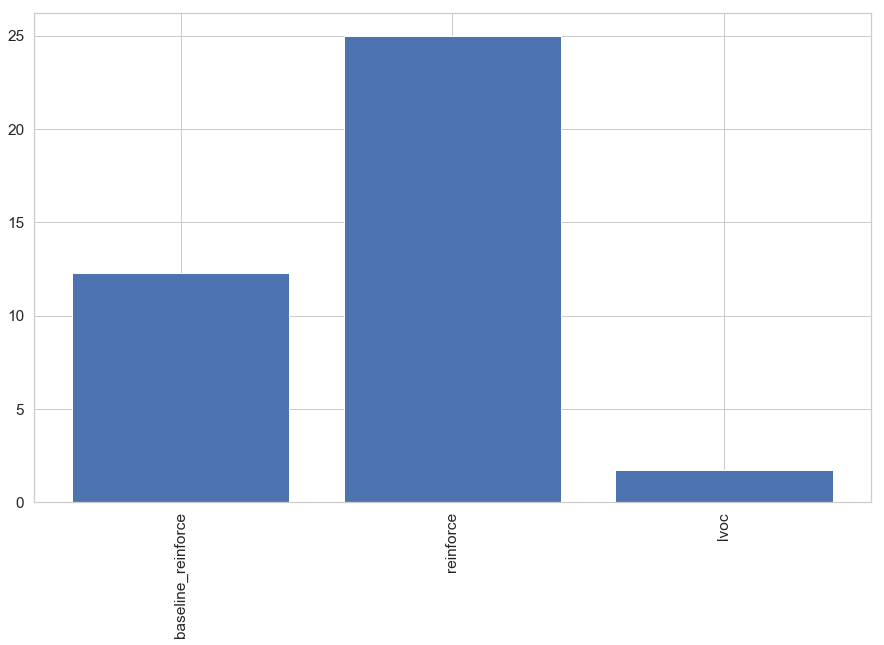

In [24]:
labels, values = zip(*model_selections.items())
plt.figure(figsize = (15, 9))
plt.bar(labels, values)
plt.xticks(rotation='vertical')
plt.savefig("results/model_selection_tie_break.png", bbox_inches='tight')

In [25]:
z = display_df.groupby(['pid'], as_index=False)

In [26]:
print(display_df)

     pid               model   criterion base_learner decision_rule     pr  \
302    1  baseline_reinforce  likelihood         None          None   true   
147    1           reinforce  likelihood         None          None   true   
307    2  baseline_reinforce  likelihood         None          None   true   
156    6           reinforce  likelihood         None          None  false   
157    6           reinforce  likelihood         None          None  false   
315    9  baseline_reinforce  likelihood         None          None   true   
161    9           reinforce  likelihood         None          None  false   
160    9           reinforce  likelihood         None          None  false   
162   11           reinforce  likelihood         None          None   true   
166   14           reinforce  likelihood         None          None   true   
171   18           reinforce  likelihood         None          None   true   
332   21  baseline_reinforce  likelihood         None          N

1
1
2
6
6
9
9
9
11
14
18
21
21
24
24
24
24
24
24
24
24
24
24
24
27
37
38
44
50
50
55
55
55
55
56
58
58
66
66
76
76
79
85
89
89
90
98
99
99
100
104
104
104
104
104
104
104
111
111
113
118
119
123
123
126
129
129
129
129
139
142
144
153
153
153
153
153
153
153
153
153
153
153
154


//anaconda3/envs/cogtut/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


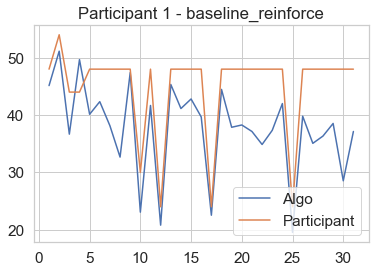

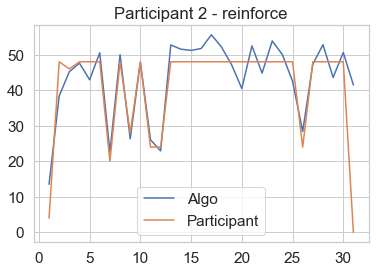

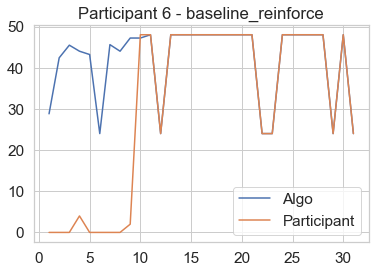

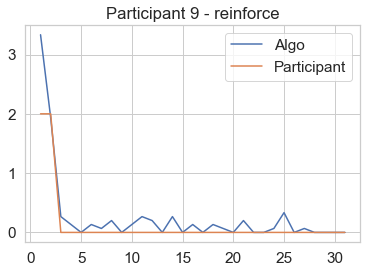

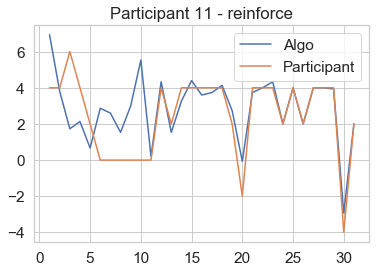

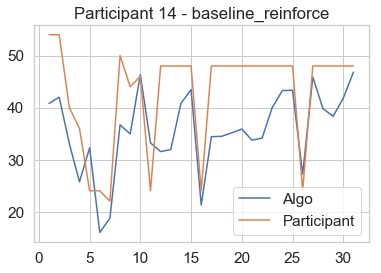

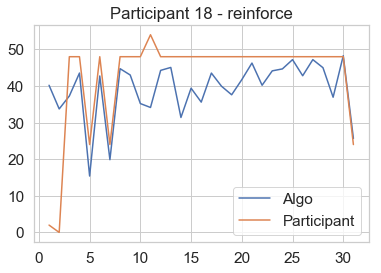

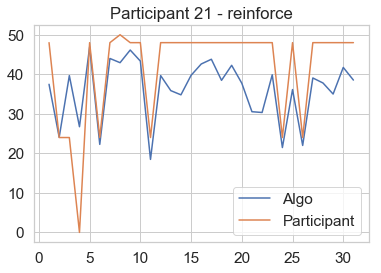

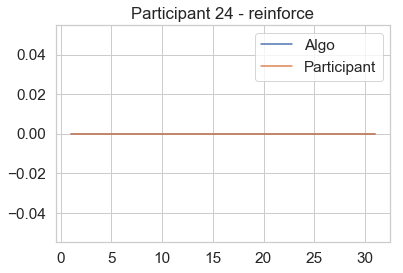

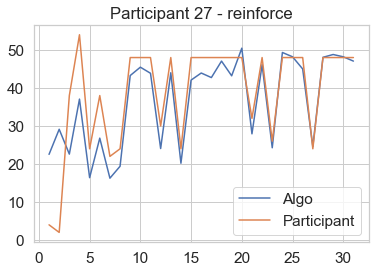

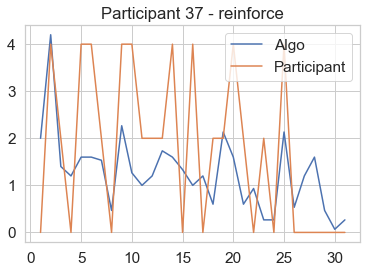

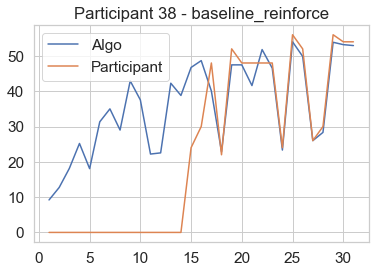

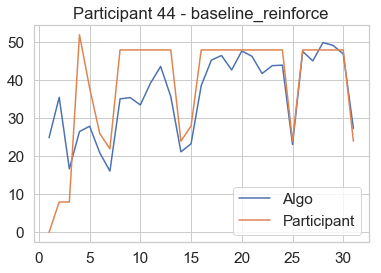

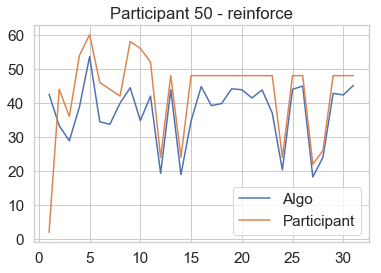

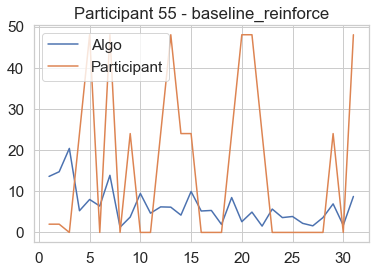

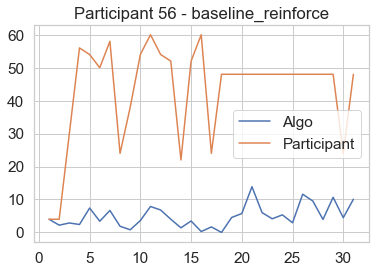

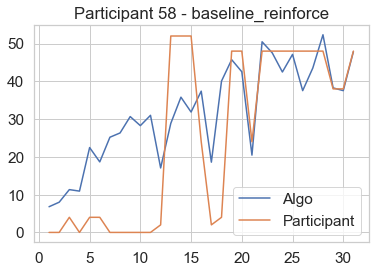

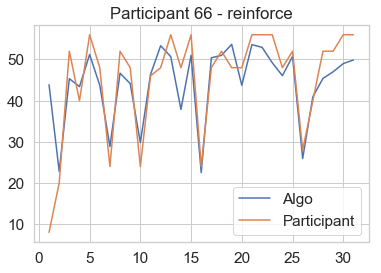

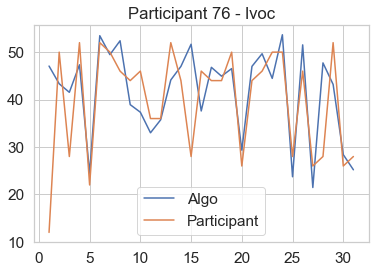

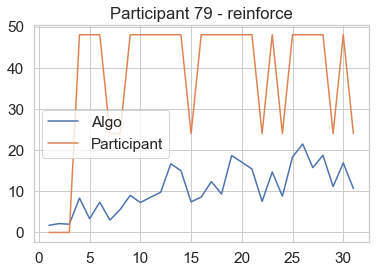

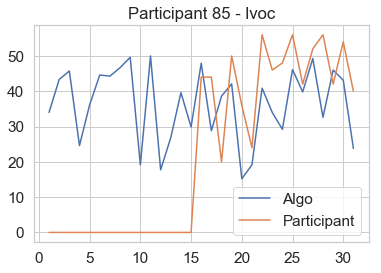

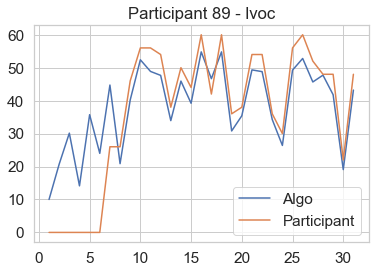

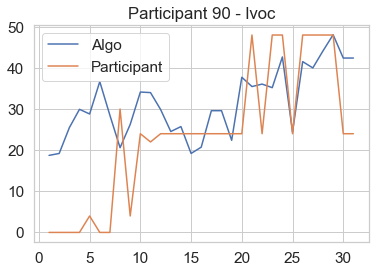

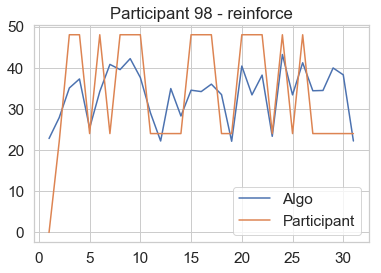

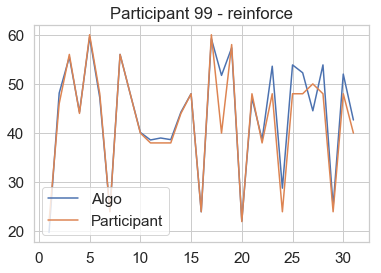

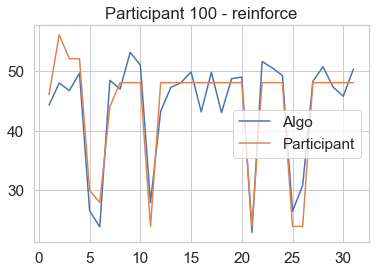

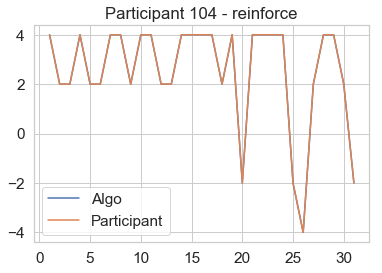

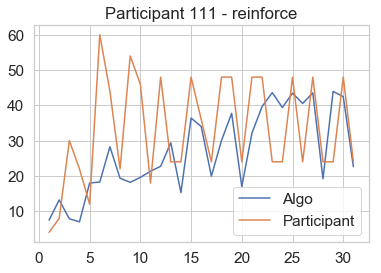

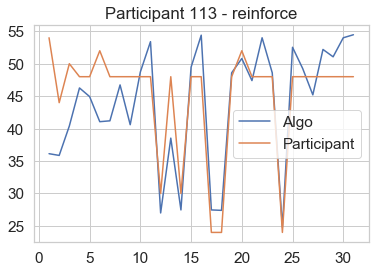

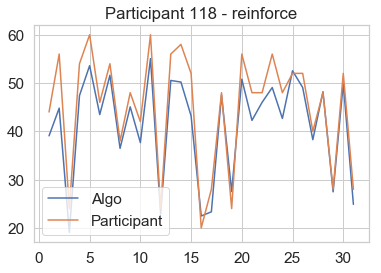

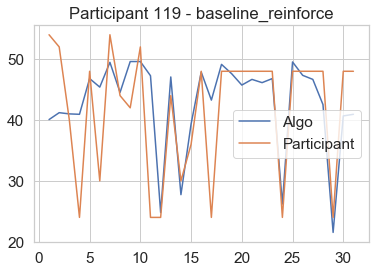

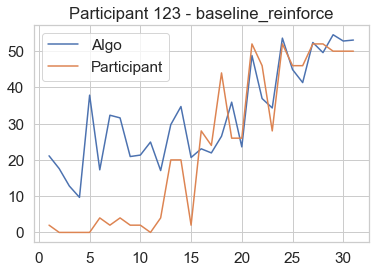

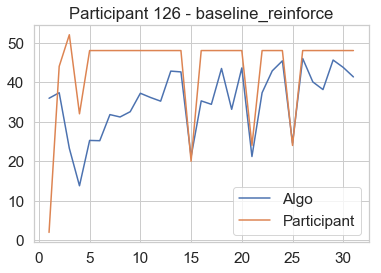

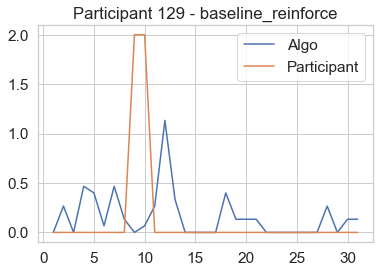

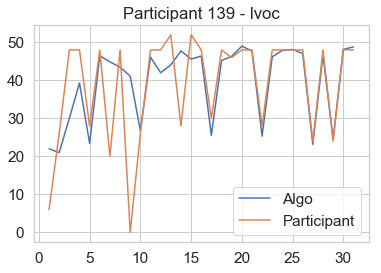

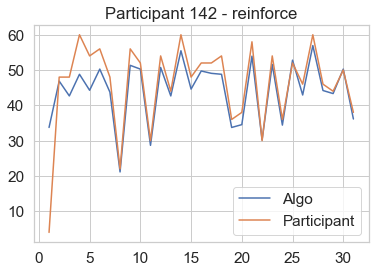

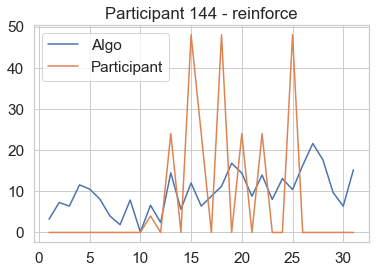

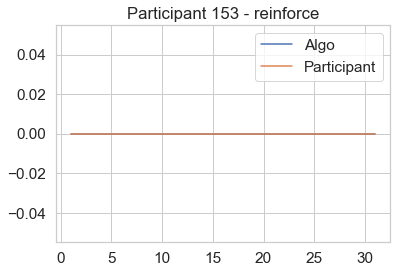

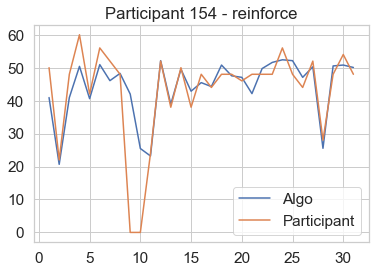

In [27]:
AMER, PMER = get_mer_df(best_df)
model_names = [v[1] for v in best_df.values]
for i, pid in enumerate(control_pids):
    plt.figure()
    plt.title(f"Participant {pid} - {model_names[i]}")
    plt.plot(range(1, 32), AMER[pid], label = 'Algo')
    plt.plot(range(1, 32), PMER[pid], label = 'Participant')
    plt.legend()

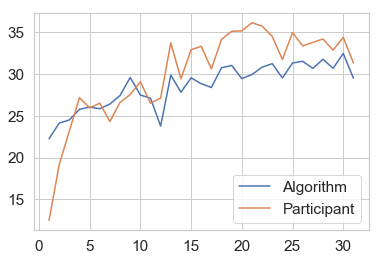

In [28]:
mean_AMER = np.mean(list(AMER.values()), axis = 0)
mean_PMER = np.mean(list(PMER.values()), axis = 0)
plt.plot(range(1, 32), mean_AMER, label = 'Algorithm')
plt.plot(range(1, 32), mean_PMER, label = 'Participant')
plt.legend()
plt.savefig("results/max_expected_returns.png")

In [29]:
p_scores = []
for pid in best_df.pid.values:
    p = Participant("F1", pid)
    scores = p.scores
    p_scores.append(scores)

1
1
2
6
6
9
9
9
11
14
18
21
21
24
24
24
24
24
24
24
24
24
24
24
27
37
38
44
50
50
55
55
55
55
56
58
58
66
66
76
76
79
85
89
89
90
98
99
99
100
104
104
104
104
104
104
104
111
111
113
118
119
123
123
126
129
129
129
129
139
142
144
153
153
153
153
153
153
153
153
153
153
153
154


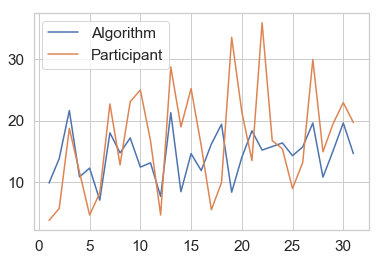

In [31]:
R = np.mean(best_df['R'].values, axis=0)
plt.plot(range(1, 32), R, label = 'Algorithm')
plt.plot(range(1, 32), np.mean(p_scores, axis =0), label='Participant')
plt.legend()
plt.savefig("results/mean_rewards.png")

1
2
6
9
11
14
18
21
24
27
37
38
44
50
55
56
58
66
76
79
85
89
90
98
99
100
104
111
113
118
119
123
126
129
139
142
144
153
154


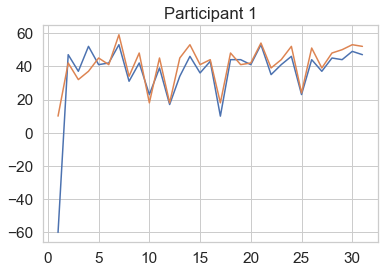

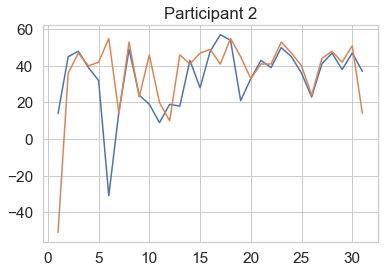

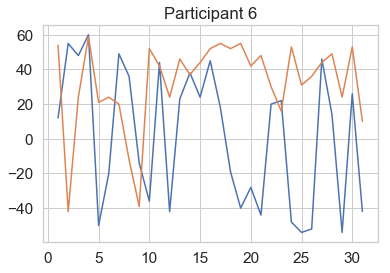

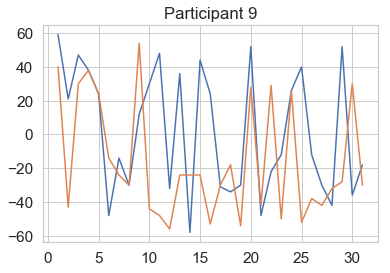

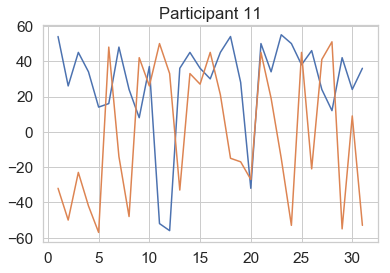

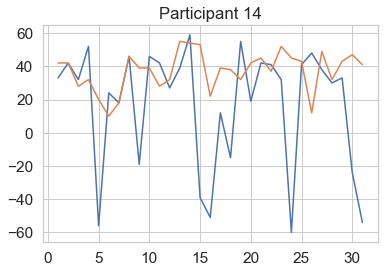

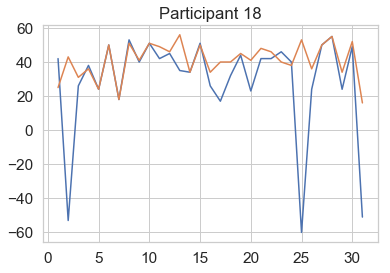

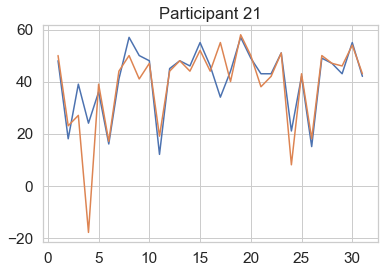

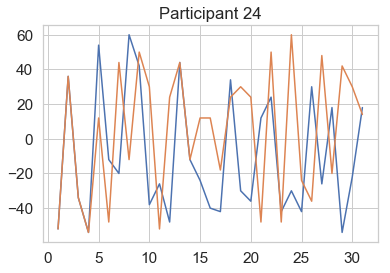

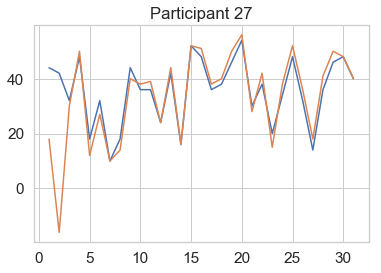

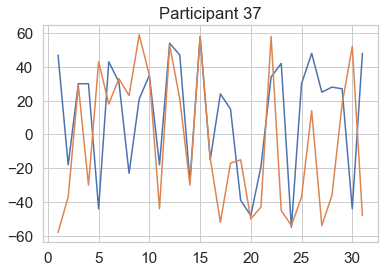

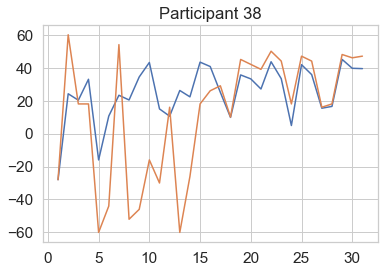

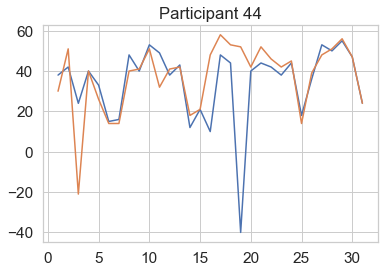

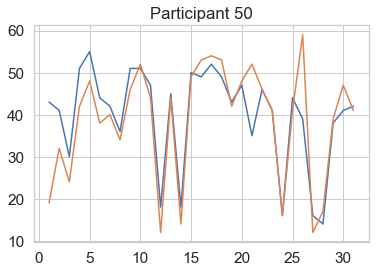

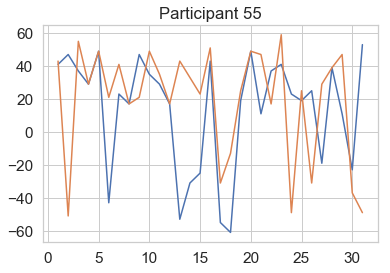

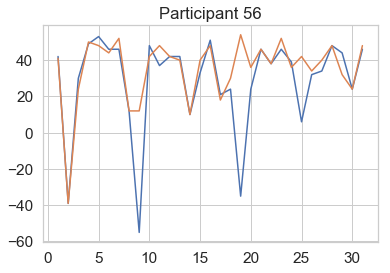

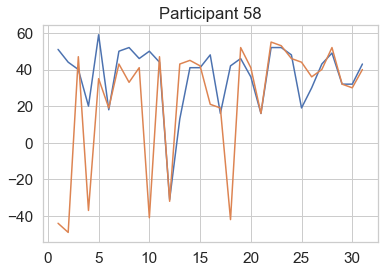

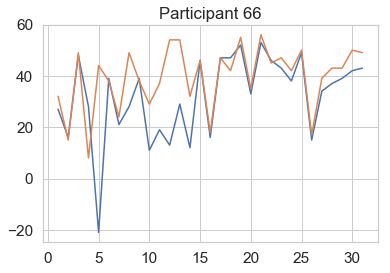

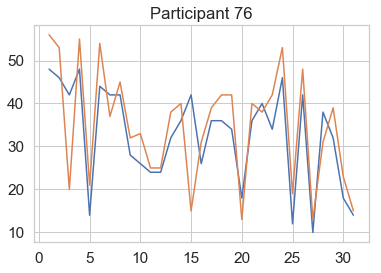

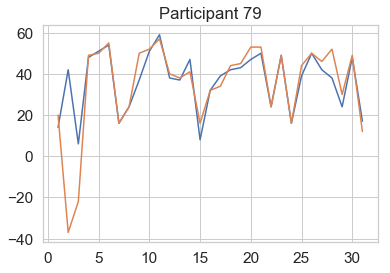

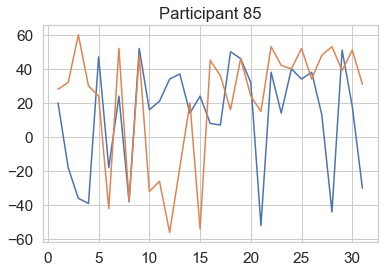

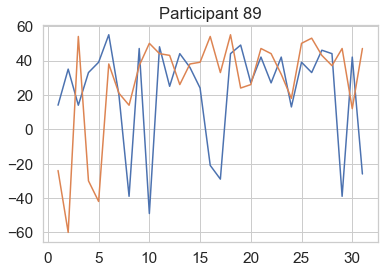

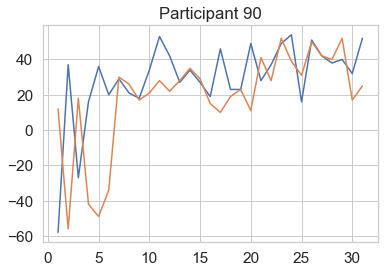

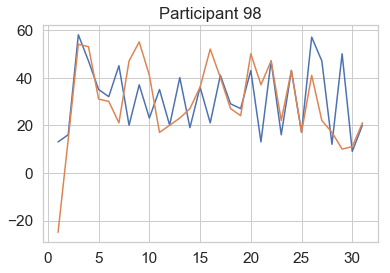

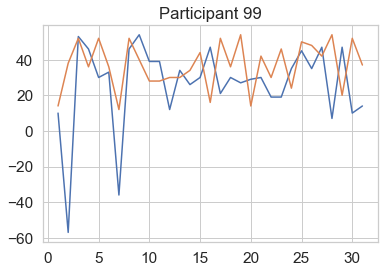

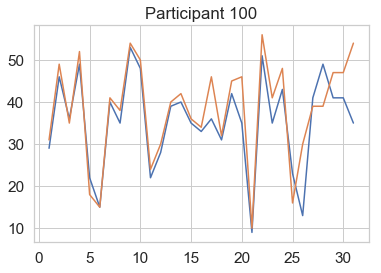

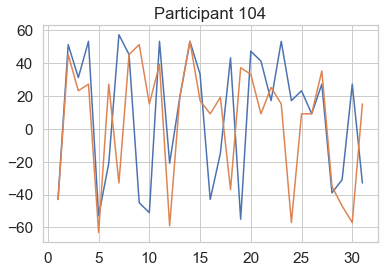

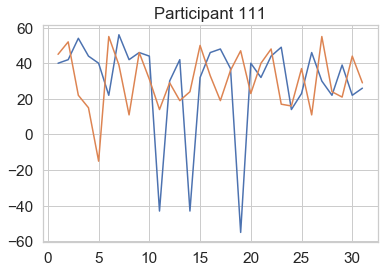

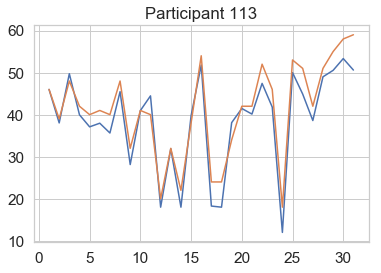

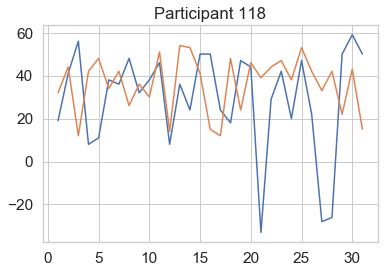

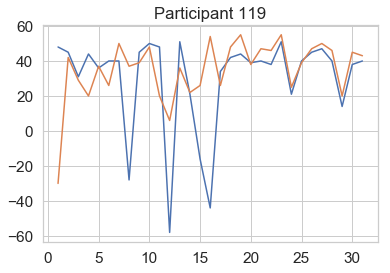

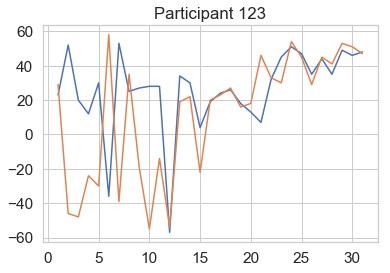

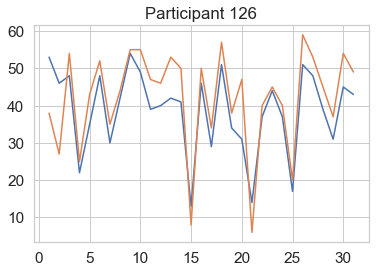

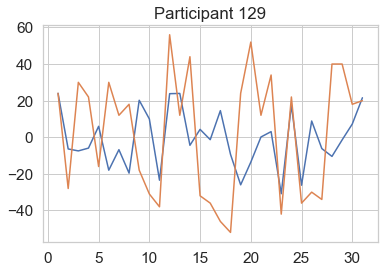

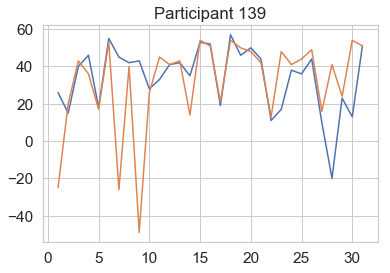

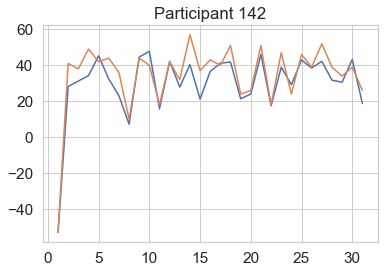

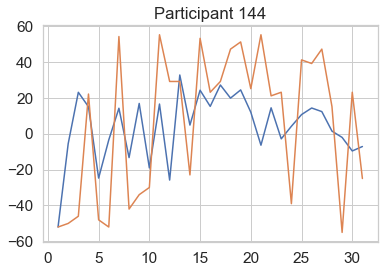

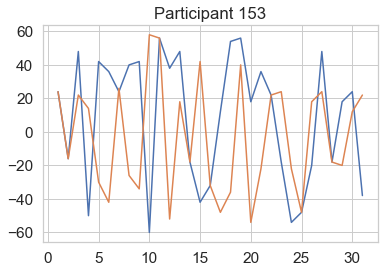

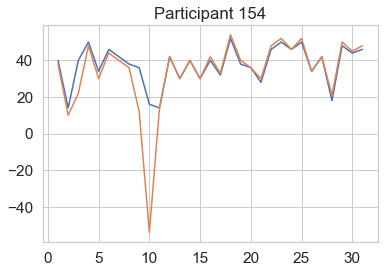

In [245]:
for pid in best_df.pid.values:
    r = best_df[best_df.pid == pid]['R'].values[0]
    p = Participant("F1", pid)
    plt.figure()
    plt.title(f"Participant {pid}")
    plt.plot(range(1, 32), r, label = 'Algorithm')
    plt.plot(range(1, 32), p.scores, label = 'Participant')

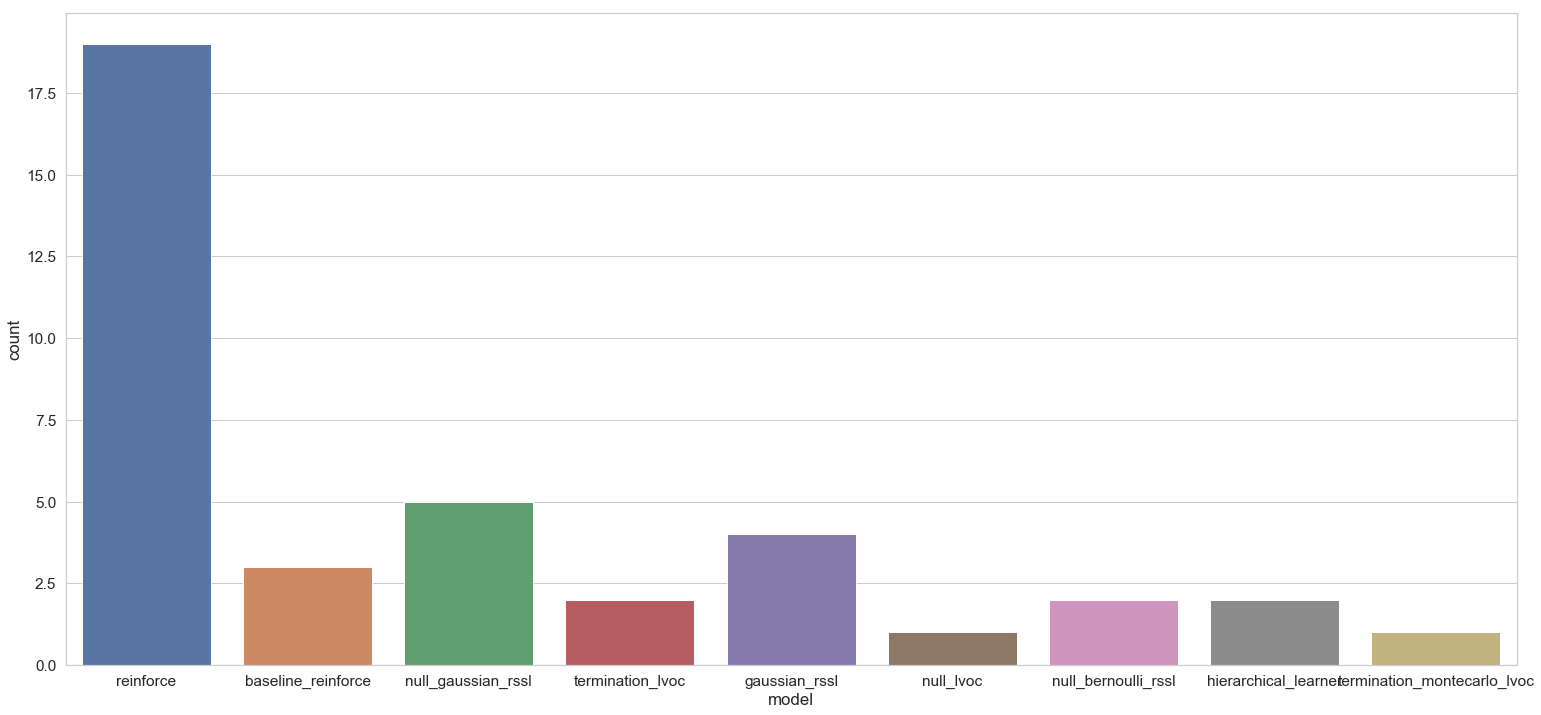

In [262]:
import seaborn as sns
plt.figure(figsize=(26,12))
sns.countplot(best_df['model'])
plt.savefig("results/model_counts.png")

In [261]:
pd.options.display.max_rows = 300
display(df[df.pid == 24][df.model == "null_lvoc"])

//anaconda3/envs/cogtut/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


pid      model   criterion base_learner decision_rule     pr    prw  \
1280   24  null_lvoc  likelihood         None          None   true   true   
1281   24  null_lvoc  likelihood         None          None   true  false   
1282   24  null_lvoc  likelihood         None          None  false   true   
1283   24  null_lvoc  likelihood         None          None  false  false   

      term  mode  NUM_PARAMS       NLL         AIC  \
1280  None  None          60  0.049306  120.098612   
1281  None  None          59  0.033319  118.066638   
1282  None  None          59  0.105442  118.210884   
1283  None  None          59  0.105442  118.210884   

                                                      A  \
1280  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...   
1281  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...   
1282  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...   
1283  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...   

                                                      R  
1280  [-52.0, -13.466666666666667, -3.6, -26.4, -20....  
1281  [-52.0, -0.6, 10.4, -26.4, -15.0, 4.4, -7.2, -...  
1282  [-52.0, -0.6, -2.2666666666666666, -17.6, -17....  
1283  [-52.0, -0.6, -2.2666666666666666, -17.6, -17....

In [ ]:

x = ds_df.groupby(['pid', 'criterion'], as_index=False)['loss'].idxmin()
best_df = ds_df.iloc[x.values]
best_df = best_df[best_df.pid.isin(control_pids)]
display(best_df)

### Get number of clicks of each participant in an experiment

In [104]:
models = ['bernoulli_rssl', 'gaussian_rssl']
priors = defaultdict(lambda: defaultdict())
for model in models:
    for pid in range(155):
        priors[model][pid] = pickle_load(f"results/temp_results/{model}/likelihood/normalized/{pid}.pkl")['params']

In [2]:
exp_num = "F1"
p_num_clicks = pickle_load(f"data/num_clicks_{exp_num}.pkl")

FileNotFoundError: data/num_clicks_F1.pkl not found.

In [97]:
paths = glob('results/temp_results/*')
paths.remove('results/temp_results/hierarchical_learner')
ds_df = []
for path in paths:
    for c in ['reward', 'performance_error']:
        d = f"{path}/{c}/normalized/"
        try:
            files = os.listdir(f"{d}")
            for file in files:
                val = pickle_load(f"{d}/{file}")
                loss = val['loss']
                num_params = len(val['params'])
                ds_df.append([d, int(file.split(".")[0]), loss, c])
        except Exception as e:
            continue

In [101]:
ds_df = pd.DataFrame(ds_df, columns = ["model", "pid", "loss", "criterion"])
x = ds_df.groupby(['pid', 'criterion'], as_index=False)['loss'].idxmin()
best_df = ds_df.iloc[x.values]
best_df = best_df[best_df.pid.isin(control_pids)]
display(best_df)

model  pid         loss  \
931  results/temp_results/ds_pr_prw/performance_err...    1    35.373405   
268  results/temp_results/termination_montecarlo_ds...    1   -41.273118   
700  results/temp_results/termination_ds_pr_prw/per...    2    84.707455   
271  results/temp_results/termination_montecarlo_ds...    2   -39.474194   
611  results/temp_results/ds_pr/performance_error/n...    6   462.802903   
182         results/temp_results/ds/reward/normalized/    6   -39.663441   
939  results/temp_results/lvoc_op_pr/performance_er...    9   547.636129   
159         results/temp_results/ds/reward/normalized/    9   -37.596774   
678  results/temp_results/termination_ds_pr_prw/per...   11  1113.416918   
171         results/temp_results/ds/reward/normalized/   11   -39.567742   
283  results/temp_results/termination_montecarlo_ds...   14    30.471111   
244  results/temp_results/termination_montecarlo_ds...   14   -39.694624   
763  results/temp_results/termination_ds/performanc...   18    19.420573   
178         results/temp_results/ds/reward/normalized/   18   -41.290323   
760  results/temp_results/termination_ds/performanc...   21    73.806165   
565      results/temp_results/ds_pr/reward/normalized/   21   -38.507527   
956  results/temp_results/lvoc_op_pr/performance_er...   24   379.951505   
101  results/temp_results/montecarlo_ds_pr_prw/rewa...   24   -38.703226   
220  results/temp_results/ds/performance_error/norm...   27    79.206129   
727  results/temp_results/termination_ds/reward/nor...   27   -36.016129   
951  results/temp_results/lvoc_op_pr/performance_er...   37   640.211577   
251  results/temp_results/termination_montecarlo_ds...   37   -40.973118   
946  results/temp_results/lvoc_op_pr/performance_er...   38   416.438423   
713  results/temp_results/termination_ds/reward/nor...   38   -38.469892   
780  results/temp_results/termination_ds/performanc...   44    59.128925   
507  results/temp_results/termination_ds_pr/reward/...   44   -37.870968   
623  results/temp_results/ds_pr/performance_error/n...   50    28.354767   
506  results/temp_results/termination_ds_pr/reward/...   50   -39.195699   
959  results/temp_results/lvoc_op_pr/performance_er...   55   725.944731   
574      results/temp_results/ds_pr/reward/normalized/   55   -37.860215   
693  results/temp_results/termination_ds_pr_prw/per...   56    97.362186   
264  results/temp_results/termination_montecarlo_ds...   56   -39.888172   
943  results/temp_results/lvoc_op_pr/performance_er...   58   564.171219   
709  results/temp_results/termination_ds/reward/nor...   58   -39.694624   
747  results/temp_results/termination_ds/performanc...   66    16.428100   
240  results/temp_results/termination_montecarlo_ds...   66   -40.251613   
820  results/temp_results/montecarlo_ds_pr/performa...   76    55.408495   
703  results/temp_results/termination_ds/reward/nor...   76   -37.952688   
542  results/temp_results/termination_ds_pr/perform...   79   144.908817   
191         results/temp_results/ds/reward/normalized/   79   -36.852688   
961  results/temp_results/lvoc_op_pr/performance_er...   85   449.272616   
187         results/temp_results/ds/reward/normalized/   85   -41.144086   
938  results/temp_results/lvoc_op_pr/performance_er...   89   231.102652   
548      results/temp_results/ds_pr/reward/normalized/   89   -41.190323   
618  results/temp_results/ds_pr/performance_error/n...   90   548.136667   
657  results/temp_results/termination_ds_pr_prw/rew...   90   -40.018280   
433  results/temp_results/termination_montecarlo_ds...   98   135.265520   
706  results/temp_results/termination_ds/reward/nor...   98   -38.843011   
43   results/temp_results/montecarlo_ds/performance...   99    12.770143   
551      results/temp_results/ds_pr/reward/normalized/   99   -37.559140   
46   results/temp_results/montecarlo_ds/performance...  100    14.963835   
710  results/temp_results/termination_ds/reward/nor...  100   -39.269892   
948  results/temp_res

In [88]:
from glob import glob
paths = glob('results/temp_results/*')
paths.remove('results/temp_results/hierarchical_learner')
df = []
for path in paths:
    d = f"{path}/likelihood/normalized/"
    try:
        files = os.listdir(f"{d}")
        for file in files:
            val = pickle_load(f"{d}/{file}")
            loss = val['loss']
            num_params = len(val['params'])
            df.append([d, int(file.split(".")[0]), loss, num_params, loss + 2*num_params])
    except Exception as e:
        continue
d = f"results/temp_results/hierarchical_learner"
dirs = os.listdir(d)
for ds in dirs:
    try:
        p = f"{d}/{ds}/likelihood/normalized"
        files = os.listdir(p)
        for file in files:
            val = pickle_load(f"{p}/{file}")
            loss = val['loss']
            num_params = len(val['params'])
            df.append([p, int(file.split(".")[0]), loss, num_params, loss + 2*num_params])
    except Exception as e:
        print(e)

In [102]:
df = pd.DataFrame(df, columns = ['model', 'pid', 'loss', 'num_params', 'AIC'])
df = df.sort_values(['pid', 'loss'])
display(df)
x = df.groupby('pid', as_index=False)['AIC'].idxmin()
best_df = df.iloc[x.values]
best_df = best_df[best_df.pid.isin(control_pids)]
display(best_df)

model  pid         loss  \
204   results/temp_results/bernoulli_rssl/likelihood...    0   440.086105   
1167  results/temp_results/bernoulli_rssl_pr/likelih...    0   458.269023   
1013  results/temp_results/bernoulli_rssl_pr_prw/lik...    0   466.789828   
858   results/temp_results/gaussian_rssl/likelihood/...    0  4015.961143   
1516  results/temp_results/gaussian_rssl_pr_prw/like...    0  4762.474358   
356   results/temp_results/gaussian_rssl_pr/likeliho...    0  5167.945182   
368   results/temp_results/gaussian_rssl_pr/likeliho...    1   240.167757   
1528  results/temp_results/gaussian_rssl_pr_prw/like...    1   241.465686   
870   results/temp_results/gaussian_rssl/likelihood/...    1   242.188192   
1025  results/temp_results/bernoulli_rssl_pr_prw/lik...    1   317.989262   
1965  results/temp_results/termination_montecarlo_lv...    1   320.379782   
2004  results/temp_results/vicarious_lvoc_op/likelih...    1   324.842010   
2082  results/temp_results/lvoc_op_pr/likelihood/nor...    1   327.565308   
650   results/temp_results/termination_lvoc_op_pr/li...    1   328.926569   
1771  results/temp_results/full_lvoc_op_pr/likelihoo...    1   330.405019   
535   results/temp_results/termination_lvoc_op/likel...    1   332.368015   
1229  results/temp_results/montecarlo_lvoc_op/likeli...    1   332.699234   
1179  results/temp_results/bernoulli_rssl_pr/likelih...    1   333.907239   
1307  results/temp_results/cost_lvoc_op_pr/likelihoo...    1   334.923831   
1693  results/temp_results/full_lvoc_op/likelihood/n...    1   335.341690   
216   results/temp_results/bernoulli_rssl/likelihood...    1   335.537759   
2121  results/temp_results/cost_lvoc_op/likelihood/n...    1   337.452150   
1810  results/temp_results/montecarlo_lvoc_op_pr/lik...    1   341.622574   
1888  results/temp_results/vicarious_lvoc_op_pr/like...    1   341.952905   
72    results/temp_results/cost_term_mc_lvoc_op/like...    1   343.452632   
2043  results/temp_results/termination_montecarlo_lv...    1   347.036065   
457   results/temp_results/cost_term_mc_lvoc_op_pr/l...    1   347.385753   
574   results/temp_results/lvoc_op/likelihood/normal...    1   362.335049   
1926  results/temp_results/termination_lvoc_pr/likel...    1   364.390419   
1732  results/temp_results/cost_lvoc/likelihood/norm...    1   365.107192   
33     results/temp_results/lvoc/likelihood/normalized/    1   365.514173   
496   results/temp_results/vicarious_lvoc_pr/likelih...    1   365.653269   
1384  results/temp_results/montecarlo_lvoc/likelihoo...    1   366.192188   
611   results/temp_results/termination_montecarlo_lv...    1   366.263233   
1849  results/temp_results/cost_term_mc_lvoc_pr/like...    1   366.297320   
689   results/temp_results/vicarious_lvoc/likelihood...    1   366.548540   
1617  results/temp_results/termination_lvoc/likeliho...    1   366.908300   
2159  results/temp_results/lvoc_pr/likelihood/normal...    1   367.102724   
1654  results/temp_results/cost_term_mc_lvoc/likelih...    1   367.280930   
726   results/temp_results/cost_lvoc_pr/likelihood/n...    1   367.285970   
418   results/temp_results/termination_montecarlo_lv...    1   370.319307   
1578  results/temp_results/montecarlo_lvoc_pr/likeli...    1   370.793305   
1268  results/temp_results/full_lvoc/likelihood/norm...    1   371.302040   
1346  results/temp_results/full_lvoc_pr/likelihood/n...    1   372.454780   
3475  results/temp_results/hierarchical_learner/lvoc...    1   382.938396   
4484  results/temp_results/hierarchical_learner/mont...    1   390.530530   
2584  results/temp_results/hierarchical_learner/term...    1   393.663633   
2467  results/temp_results/hierarchical_learner/full...    1   396.071245   
2855  results/temp_results/hierarchical_learner/lvoc...    1   400.210572   
2661  results/temp_results/hierarchical_learner/cost...    1   400.790978   
2933  results/temp_results/hierarchical_learner/mont...    1   403.459408   
5065  results/temp_results/hierarchical_learne

model  pid        loss  \
5491  results/temp_results/hierarchical_learner/term...    2  387.103187   
3055  results/temp_results/hierarchical_learner/term...   44  470.538454   
2334  results/temp_results/hierarchical_learner/cost...   11  256.709331   
1756  results/temp_results/full_lvoc_op_pr/likelihoo...   21  279.227685   
2263  results/temp_results/hierarchical_learner/term...   18  429.310012   
5516  results/temp_results/hierarchical_learner/lvoc...   24   21.521687   
2664  results/temp_results/hierarchical_learner/cost...    2  369.896909   
4174  results/temp_results/hierarchical_learner/vica...    1  419.686429   
2417  results/temp_results/hierarchical_learner/lvoc...   24   20.561312   
3616  results/temp_results/hierarchical_learner/cost...   21  364.796723   
399   results/temp_results/termination_montecarlo_lv...   11  158.796022   
2843  results/temp_results/hierarchical_learner/lvoc...   18  378.811383   
4198  results/temp_results/hierarchical_learner/cost...   21  369.915389   
5207  results/temp_results/hierarchical_learner/vica...   24   21.132224   
2367  results/temp_results/hierarchical_learner/cost...   14  418.513146   
2724  results/temp_results/hierarchical_learner/term...   21  353.014552   
4740  results/temp_results/hierarchical_learner/term...   21  358.837216   
4356  results/temp_results/hierarchical_learner/cost...   24   21.519125   
1696  results/temp_results/full_lvoc_op/likelihood/n...    2  312.253364   
5400  results/temp_results/hierarchical_learner/mont...   18  381.581001   
4625  results/temp_results/hierarchical_learner/vica...   21  373.138774   
4628  results/temp_results/hierarchical_learner/vica...   18  378.955281   
5816  results/temp_results/hierarchical_learner/lvoc...   11  252.668056   
2046  results/temp_results/termination_montecarlo_lv...    2  312.214412   
1735  results/temp_results/cost_lvoc/likelihood/norm...    2  329.228346   
4782  results/temp_results/hierarchical_learner/cost...   24   21.521238   
3385  results/temp_results/hierarchical_learner/cost...   18  373.437777   
3709  results/temp_results/hierarchical_learner/cost...    1  452.135707   
4769  results/temp_results/hierarchical_learner/cost...   14  445.990699   
4937  results/temp_results/hierarchical_learner/term...   18  384.645503   
4508  results/temp_results/hierarchical_learner/mont...   21  404.023886   
5515  results/temp_results/hierarchical_learner/lvoc...   18  411.130696   
1193  results/temp_results/bernoulli_rssl_pr/likelih...    2  300.396967   
1813  results/temp_results/montecarlo_lvoc_op_pr/lik...    2  310.374079   
538   results/temp_results/termination_lvoc_op/likel...    2  299.059500   
5323  results/temp_results/hierarchical_learner/cost...   24   21.328576   
2450  results/temp_results/hierarchical_learner/full...   37  132.980525   
2379  results/temp_results/hierarchical_learner/cost...   18  377.354148   
5206  results/temp_results/hierarchical_learner/vica...   18  412.553921   
3958  results/temp_results/hierarchical_learner/cost...   14  499.423713   
5146  results/temp_results/hierarchical_learner/full...    2  373.946810   
4049  results/temp_results/hierarchical_learner/vica...   24   21.532403   
3634  results/temp_results/hierarchical_learner/cost...    2  390.065704   
4434  results/temp_results/hierarchical_learner/cost...   24    0.030194   
715   results/temp_results/cost_lvoc_pr/likelihood/n...   18  303.383392   
5143  results/temp_results/hierarchical_learner/full...    1  411.482315   
2242  results/temp_results/hierarchical_learner/mont...   44  423.817733   
1678  results/temp_results/full_lvoc_op/likelihood/n...   21  282.816656   
2819  results/temp_results/hierarchical_learner/cost...    2  386.830046   
61    results/temp_results/cost_term_mc_lvoc_op/like...   24    0.030199   
3868  results/temp_results/hierarchical_learner/term...    2  360.972609   
4738  results/temp_results/hierarchical_learner/term...   37  136.933927   
4314  results/temp_res

In [80]:
print(len(best_df))

39


In [81]:
best_df.groupby('model').describe()

pid              \
                                                   count        mean   
model                                                                  
results/temp_results/cost_lvoc/likelihood/norma...   1.0   79.000000   
results/temp_results/cost_lvoc_pr/likelihood/no...   3.0   91.333333   
results/temp_results/full_lvoc/likelihood/norma...   7.0   22.142857   
results/temp_results/full_lvoc_pr/likelihood/no...   3.0  110.333333   
results/temp_results/lvoc/likelihood/normalized/     3.0  129.000000   
results/temp_results/lvoc_pr/likelihood/normali...   1.0  111.000000   
results/temp_results/montecarlo_lvoc_pr/likelih...   3.0   50.333333   
results/temp_results/termination_lvoc/likelihoo...   2.0  105.500000   
results/temp_results/termination_lvoc_pr/likeli...   3.0   65.333333   
results/temp_results/termination_montecarlo_lvo...   1.0   11.000000   
results/temp_results/termination_montecarlo_lvo...   1.0   56.000000   
results/temp_results/termination_montecarlo_lvo...   1.0   98.000000   
results/temp_results/vicarious_lvoc/likelihood/...   5.0   73.200000   
results/temp_results/vicarious_lvoc_op_pr/likel...   1.0   50.000000   
results/temp_results/vicarious_lvoc_pr/likeliho...   4.0  113.000000   

                                                                              \
                                                          std    min     25%   
model                                                                          
results/temp_results/cost_lvoc/likelihood/norma...        NaN   79.0   79.00   
results/temp_results/cost_lvoc_pr/likelihood/no...  66.830632   21.0   60.00   
results/temp_results/full_lvoc/likelihood/norma...  14.369279    6.0   11.50   
results/temp_results/full_lvoc_pr/likelihood/no...  27.970222   89.0   94.50   
results/temp_results/lvoc/likelihood/normalized/    34.073450   90.0  117.00   
results/temp_results/lvoc_pr/likelihood/normali...        NaN  111.0  111.00   
results/temp_results/montecarlo_lvoc_pr/likelih...  10.785793   38.0   46.50   
results/temp_results/termination_lvoc/likelihoo...  28.991378   85.0   95.25   
results/temp_results/termination_lvoc_pr/likeli...  64.002604    1.0   33.50   
results/temp_results/termination_montecarlo_lvo...        NaN   11.0   11.00   
results/temp_results/termination_montecarlo_lvo...        NaN   56.0   56.00   
results/temp_results/termination_montecarlo_lvo...        NaN   98.0   98.00   
results/temp_results/vicarious_lvoc/likelihood/...  55.907960    2.0   24.00   
results/temp_results/vicarious_lvoc_op_pr/likel...        NaN   50.0   50.00   
results/temp_results/vicarious_lvoc_pr/likeliho...  26.495283   76.0  107.50   

                                                                          \
                                                      50%     75%    max   
model                                                                      
results/temp_results/cost_lvoc/likelihood/norma...   79.0   79.00   79.0   
results/temp_results/cost_lvoc_pr/likelihood/no...   99.0  126.50  154.0   
results/temp_results/full_lvoc/likelihood/norma...   18.0   32.00   44.0   
results/temp_results/full_lvoc_pr/likelihood/no...  100.0  121.00  142.0   
results/temp_results/lvoc/likelihood/normalized/    144.0  148.50  153.0   
results/temp_results/lvoc_pr/likelihood/normali...  111.0  111.00  111.0   
results/temp_results/montecarlo_lvoc_pr/likelih...   55.0   56.50   58.0   
results/temp_results/termination_lvoc/likelihoo...  105.5  115.75  126.0   
results/temp_results/termination_lvoc_pr/likeli...   66.0   97.50  129.0   
results/temp_results/termination_montecarlo_lvo...   11.0   11.00   11.0   
results/temp_results/termination_montecarlo_lvo...   56.0   56.00   56.0   
results/temp_results/termination_montecarlo_lvo...   98.0   98.00   98.0   
results/temp_results/vicarious_lvoc/likelihood/...  104.0  113.00  123.0   
results/temp_results/vicarious_lvoc_op_pr/likel...   50.0   50.00   50.0   
results/temp_results/vi

### All implemented models

In [3]:
# Each model except RSSL models has 2 dimensions
# First is whether or not we use Pseudo rewards
# Second is whether or not we optimize its priors
# Third is whether or not we weight the pseudo rewards
implemented_model_details = []
decision_rules = ["threshold", "adaptive_satisficing", "feature", "confidence_bound"]
models = list(rl_models.keys())
for model in models.copy():
    if "lvoc" in model:
        for decision_rule in decision_rules:
            models.append(f"H_{model}_{decision_rule}")
models.remove("hierarchical_learner")
prs = [True, False]
ops = [True, False]
pr_weights = [True, False]
for model in models:
    for op in ops:
        if "rssl" in model:
            implemented_model_details.append([model, op, False, False])
        else:
            for pr in prs:
                for pr_weight in pr_weights:
                    if not pr and pr_weight:
                        continue
                    implemented_model_details.append([model, op, pr, pr_weight])

### Getting data for a particular model

In [68]:
# For now the data is only for F1 but change the path point to the right data according to the experiment
# and also the right control pids
control_pids = [1, 2, 6, 9, 11, 14, 18, 21, 24, 27, 37, 38, 44, 50, 55, 56, 58, 66, 76, 79, 85, 89, 90, 98, 99,
                100, 104, 111, 113, 118, 119, 123, 126, 129, 139, 142, 144, 153, 154]

In [5]:
def get_model_data(model_details, path, criterion = "likelihood"):
    model_name = model_details[0]
    op = model_details[1]
    pr = model_details[2]
    pr_weight = model_details[3]
    if model_name.startswith("H_"):
        path += "/hierarchical_learner/"
        model_name = model_name[2:]
    else:
        path += "/"
    path += model_name
    if op:
        path += "_op"
    if pr:
        path += "_pr"
    # TODO:
    # Add for pr_weight
    path += "/likelihood/normalized/"
    total_data = {}
    for pid in control_pids:
        try:
            total_path = path + f"{pid}.pkl"
            data = pickle_load(total_path)
            total_data[pid] = data
        except FileNotFoundError:
#             print(model_name)
#             print(f"Data for participant {pid} not found")
            pass
    return total_data

### Example

In [6]:
data = []
data_path = "results/temp_results"
for model_details in implemented_model_details:
    total_participant_data = get_model_data(model_details, path = data_path)
    for pid in total_participant_data.keys():
        num_params = len(total_participant_data[pid]['params'])
        loss = total_participant_data[pid]['loss']
        data.append(model_details + [pid, num_params, loss])
    pass
participant_df = pd.DataFrame(data, columns = ['MODEL', 'OP', 'PR', 'PR_WEIGHT', 'PID', 'NUM_PARAMS', 'LOSS'])

In [7]:
participant_df['AV_CL_LIK'] = participant_df.apply(lambda x: np.exp(-x['LOSS']/p_num_clicks[x['PID']]), axis=1)
participant_df['AIC'] = 2*(participant_df['NUM_PARAMS'] + participant_df["LOSS"])

In [15]:
pd.options.display.max_rows = 1000
display(participant_df)
display(participant_df[participant_df.PID == 59])

MODEL     OP     PR  PR_WEIGHT  PID  \
0                                         lvoc   True   True       True    1   
1                                         lvoc   True   True       True    2   
2                                         lvoc   True   True       True    6   
3                                         lvoc   True   True       True    9   
4                                         lvoc   True   True       True   11   
5                                         lvoc   True   True       True   14   
6                                         lvoc   True   True       True   18   
7                                         lvoc   True   True       True   21   
8                                         lvoc   True   True       True   24   
9                                         lvoc   True   True       True   27   
10                                        lvoc   True   True       True   37   
11                                        lvoc   True   True       True   38   
12                                        lvoc   True   True       True   44   
13                                        lvoc   True   True       True   50   
14                                        lvoc   True   True       True   55   
15                                        lvoc   True   True       True   56   
16                                        lvoc   True   True       True   58   
17                                        lvoc   True   True       True   66   
18                                        lvoc   True   True       True   76   
19                                        lvoc   True   True       True   79   
20                                        lvoc   True   True       True   85   
21                                        lvoc   True   True       True   89   
22                                        lvoc   True   True       True   90   
23                                        lvoc   True   True       True   98   
24                                        lvoc   True   True       True   99   
25                                        lvoc   True   True       True  100   
26                                        lvoc   True   True       True  104   
27                                        lvoc   True   True       True  111   
28                                        lvoc   True   True       True  113   
29                                        lvoc   True   True       True  118   
30                                        lvoc   True   True       True  119   
31                                        lvoc   True   True       True  123   
32                                        lvoc   True   True       True  126   
33                                        lvoc   True   True       True  129   
34                                        lvoc   True   True       True  139   
35                                        lvoc   True   True       True  142   
36                                        lvoc   True   True       True  144   
37                                        lvoc   True   True       True  153   
38                                        lvoc   True   True       True  154   
39                                        lvoc   True   True      False    1   
40                                        lvoc   True   True      False    2   
41                                        lvoc   True   True      False    6   
42                                        lvoc   True   True      False    9   
43                                        lvoc   True   True      False   11   
44                                        lvoc   True   True      False   14   
45                                        lvoc   True   True      False   18   
46                                        lvoc   True   True      False   21   
47                                        lvoc   True   True      False   24   
48                                        lvoc   True   True      False   27   
49                                       

Empty DataFrame
Columns: [MODEL, OP, PR, PR_WEIGHT, PID, NUM_PARAMS, LOSS]
Index: []

### Getting best model for each participant

In [ ]:
x = participant_df
x = x.groupby('PID')['LOSS'].idxmin()
best_df = participant_df.iloc[x.values]

In [ ]:
strategies = pickle_load("data/inferred_sequences_F1.pkl")

In [ ]:
pid = 154
print(strategies[pid])

In [ ]:
display(best_df)

### Plotting model frequencies

In [ ]:
plt.hist(list(best_df['MODEL'].values))
plt.xticks(rotation = 90)

### Plot best fits

### Getting participant data

In [ ]:
p_data = {}
for pid in control_pids:
    p_data[pid] = Participant("F1", pid, "normalize")

### Computing chance level average likelihood per click for each participant

In [ ]:
log_vals = np.zeros(13)
log_vals[0] = np.log(13)
for i in range(1, 13):
    log_vals[i] = log_vals[i-1] + np.log(13-i)
chance_av_likelihood = []
for pid in control_pids:
    clicks_sequence = p_data[pid].clicks
    log_prod = 0
    total_clicks = 0
    for clicks in clicks_sequence:
        num_clicks = len(clicks)
        total_clicks += num_clicks
        log_prod += log_vals[num_clicks-1]
    chance_av_likelihood.append(np.exp(-log_prod/total_clicks))
print(chance_av_likelihood)

In [ ]:
best_df['Chance_AV_LL'] = chance_av_likelihood
x = best_df[['PID','Chance_AV_LL', 'AV_CL_LIK']]
x.to_csv("results/aic_avcl.csv")

### Plotting best scores

In [ ]:
from learning_utils import get_strategy_counts
plot = True
create_dir("results/best_fit_figures")
l_scores = []
p_scores = []
criterion = "likelihood"
# Add computation for strategies
for index,row in best_df.iterrows():
    pid = row['PID']
    participant = p_data[pid]
    learner = row['MODEL'].lower()
    if learner[0:2] == "h_":
        learner = f"hierarchical_learner/{learner[2:]}"
    op = row['OP']
    pr = row['PR']
    if op:
        learner += "_op"
    if pr:
        learner += "_pr"
    data = pickle_load(f"results/temp_results/{learner}/{criterion}/normalized/{pid}.pkl")
    l_scores.append(rows_mean(data['r']))
    p_scores.append(participant.scores)
    if plot:
        plt.figure(figsize = (15,9))
        plt.title("Learning Curve")
        plt.xlabel("Time Step")
        plt.ylabel("Performance")
        plt.plot(range(1,32), rows_mean(data['r']), label = {learner}, linewidth = 3.0)
        plt.plot(range(1,32), participant.scores, label = f'Participant {pid}', linewidth = 3.0)
        plt.legend()
        plt.savefig(f"results/best_fit_figures/{pid}.png")
        plt.close()

### Plot average best fit

In [ ]:
plt.figure()
plt.plot(range(1,32), rows_mean(p_scores), label = "Participant")
plt.plot(range(1,32), rows_mean(l_scores), label = "Models")
plt.legend()
plt.savefig("results/best_model_explanation_aic.png")

### Plotting best MERs

In [ ]:
def get_mers(trials, clicks_sequence):
    mers = []
    for trial, clicks in zip(trials, clicks_sequence):
        trial.reset_observations()
        for click in clicks:
            trial.node_map[click].observe()
        mer = trial.node_map[0].calculate_max_expected_return() - len(clicks)
        mers.append(mer)
    return mers

### Getting MERs of the best models

In [ ]:
criterion = "likelihood"
model_mers = []
# Add computation for strategies
for index,row in best_df.iterrows():
    pid = row['PID']
    participant = p_data[pid]
    learner = row['MODEL'].lower()
    if learner[0:2] == "h_":
        learner = f"hierarchical_learner/{learner[2:]}"
    op = row['OP']
    pr = row['PR']
    if op:
        learner += "_op"
    if pr:
        learner += "_pr"
    data = pickle_load(f"results/temp_results/{learner}/{criterion}/normalized/{pid}.pkl")
    actions = data['a']
    temp_mers = []
    envs = p_data[pid].envs
    num_trials = len(envs)
    for clicks_sequence in actions:
        pipeline = construct_pipeline([3,1,2], reward_val, num_trials)
        env = TrialSequence(
            num_trials = num_trials,
            pipeline=pipeline,
            ground_truth = envs
        )
        mers = get_mers(env.trial_sequence, clicks_sequence)
        temp_mers.append(mers)
    model_mers.append(rows_mean(temp_mers))

In [ ]:
scores = []
mer_data = {}
for pid in control_pids:
    pid_data = p_data[pid]
    scores.append(pid_data.scores)
    trials = pid_data.envs
    num_trials = len(trials)
    clicks_sequence = pid_data.clicks
    pipeline = construct_pipeline([3,1,2], reward_val, num_trials)
    env = TrialSequence(
        num_trials = num_trials,
        pipeline=pipeline,
        ground_truth = trials
    )
    mers = get_mers(env.trial_sequence, clicks_sequence)
    mer_data[pid] = mers
p_mers = list(mer_data.values())

In [ ]:
plt.plot(range(1, 32), rows_mean(p_mers), label = 'MER - N_c')
plt.plot(range(1, 32), rows_mean(model_mers), label = 'Model MERS')
plt.plot(range(1, 32), rows_mean(scores), label = 'Rewards')
plt.legend()
plt.savefig("results/mer_comparison_loss.png")
plt.show()

### Strategy frequencies

In [ ]:
l_strategies = np.array(l_strategies)
l_counts = get_strategy_counts(l_strategies)
p_counts = get_strategy_counts([p_strategies])
print(l_counts)
print(p_counts)

plot = True
if plot:
    create_dir("results/best_strategy_frequencies")
    for i in range(38):
        plt.figure()
        plt.plot(range(1,32), l_counts[:,i], label = 'Algo')
        plt.plot(range(1,32), p_counts[:,i], label = 'Participant')
        plt.legend()
        plt.savefig(f"results/best_strategy_frequencies/{i}.png")
        plt.close()

In [ ]:
#path = "results/aic_results/hierarchical_learner"
path = "results/aic_results/"
learner = "termination_lvoc"
#decision_rule = "threshold"
op = True
pr = True
path += f"/{learner}"
#path += f"/{learner}_{decision_rule}"
if op:
    path += "_op"
if pr:
    path += "_pr"
path += "/likelihood/normalized/"
pid = 1
path += f"{pid}.pkl"
data = pickle_load(path)
plt.plot(range(1, 32), rows_mean(data['r']), label = 'Algorithm')
plt.plot(range(1, 32), p_data[pid].scores, label = 'Participant')
plt.legend()